# Chatbot M2DS 2019

In [1]:
from __future__ import unicode_literals, print_function, division
import os
from io import open
import unicodedata
import string
import re
import random
import pickle
# package a installer d'abord avec anaconda
#import spacy

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# package a installer d'abord avec anaconda
import gensim
from gensim.models import KeyedVectors

#import nltk
#nltk.download()
#from nltk.tokenize import sent_tokenize, word_tokenize

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

import copy

import unidecode
from unidecode import unidecode

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import time
import math
import re
import json

In [3]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)
device = torch.device("cuda" if USE_CUDA else "cpu")

True


# 1 Training data preparation

### 1.1 Simple formatting of training dialogues

In [4]:
# -------------------- enlèvement des stopwords ---------------------------------------
def TrimWordsSentence(sentence, stopwords):
    '''Remove stopwords from a sentence'''
    resultwords = [word for word in sentence if word.lower() not in stopwords]
    return resultwords

def TrimWordsDialogue(dialogue, stopwords):
    '''Remove stopwords from user utterances in a dialogue'''
    for pair in dialogue: 
        pair[0] = TrimWordsSentence(pair[0], stopwords)
        #pair[1] = pair[1].strip()
    return dialogue

def TrimWords(dialogues, stopwords):
    '''Remove stopwords from user utterances in a list of dialogues'''
    return [TrimWordsDialogue(dialogue, stopwords) for dialogue in dialogues ]

    


# --------------------------- Normalisation -------------------------------
def normalizeString(s):
    '''Remove rare symbols from a string'''
    def unicodeToAscii(s):
        """Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427"""
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z0-9?&\%\-\_]+", r" ", s) 
    return s 



#--------------------- import des dialogues --------------------
def importDialogues(fichier, limite = None):
    '''Import a textfile containing dialogues and returns a list, each element 
       corresponding to a dialogue and also being under the form of a list, with 
       each element being a list of two elements : an element giving a user 
       utterance and another element giving the bot response. Both elements are 
       normalized strings.
       Ex. The dialogue :
       
               hi    hello what can i help you with today
               can you book a table    i m on it
               
       now becomes :
       
              [['hi', 'hello what can i help you with today'], 
               ['can you book a table', 'i m on it']]
               
       Lines corresponding to user utterance with no bot response are discarted.
    '''
    dialogues_import = open(fichier, encoding='utf-8').read().strip().split('\n\n')
    dialogues = []
    for i, d in enumerate(dialogues_import):
        dialogue = []
        lines = d.split('\n')
        for l in lines:
            if len(l.split('\t')) == 2 :
                pair = [normalizeString(s).split(' ') for s in l.split('\t')]
                dialogue.append(pair)
        dialogues.append(dialogue)
        if limite is not None and i == limite -1 :
            break

    return dialogues






#------------------ Dictionnaire des mots variables -----------------------------
def motVar(file):
    '''Applies to the Master's program dataset.
       Import the collection of pairs token-content for a set of variable words.
    '''
    lines = open(file, encoding='utf-8').read().strip().split('\n')
    motsVar = {}
    for l in lines :
        cle, valeur = l.split('\t')
        motsVar[cle.lower()] = valeur
    return motsVar




# ----------------------- Création de la liste des dialogues--------------------
def prepareData(opt):
    '''Import dialogue from text file and apply some formatting operations,
       as described in the functions 
               - importDialogues
               - modify
               - TrimWords
               - filterDialogues
    '''
    dialogues = importDialogues(fichier = opt['fichier'], 
                                limite = opt['limite'])
    dialogues = modify(dialogues) if opt['modify'] else dialogues
    dialogues = TrimWords(dialogues, opt['stopwords']) # on enlève les stopwords de chaque question
    print(" %s dialogues ..." % len(dialogues))
    print(dialogues[0])
    if opt['filtre'] :
        #for pair in [pair for pair in pairs if not filterPair(pair)]:
        #    print('%s (%d) -> %s (%d)' % (pair[0],len(pair[0].split()),pair[1],len(pair[1].split())))  
        dialogues = filterDialogues(dialogues, opt['max_length'])
        print('')
        print("... reduced to %s dialogues" % len(dialogues))

    return dialogues

In [5]:
motsVar = motVar('C:\\Users\Jb\Desktop\Scripts\data\Conversations_M2DS\\chatbot-M2-DS-Variables.txt')

Turn each dialogue of the corpus into torch variables

In [6]:
def variableFromSentence(lang, sentence, add_eos = True, rand = 0): # sentence = [str]
    indexes=[]
    unknowns = 0
    for word in sentence:
        p = random.random()
        if word not in lang.word2index.keys() and 'UNK' in lang.word2index.keys() :
            #pass
            indexes.append(lang.word2index['UNK'])
        elif p >= rand :
            indexes.append(lang.word2index[word])
        elif p < rand :
            e = random.choice([1, 2])
            if e == 1 :  # doesn't put any word
                pass
            elif e == 2 and 'UNK' in lang.word2index.keys() :# hide word with UNK_Token
                indexes.append(lang.word2index['UNK'])
    if add_eos :
        indexes.append(lang.word2index['EOS'])                                
    result = Variable(torch.LongTensor([[i] for i in indexes]))
    return result

def variableFromDialogue(lang, dialogue, rand = 0): # sentence = [str]
    result = []
    for paire in dialogue :
        el1 = variableFromSentence(lang, paire[0], rand = rand)
        el2 = variableFromSentence(lang, paire[1], rand = 0)
        result.append([el1, el2])
    return result

def variableFromAllDialogues(lang, dialogues, rand = 0): # sentence = [str]
    result = []
    for dialogue in dialogues :
        result.append(variableFromDialogue(lang, dialogue, rand = 0))
    return result

Generate dialogue corpus

In [7]:
MAX_LENGTH = 30
max_length = MAX_LENGTH
stopwords = []

Master_train =   {'fichier': 'C:\\Users\Jb\Desktop\Scripts\data\Conversations_M2DS\\Liste_Dialogues_trn.txt', #dialog-babi-task1-API-calls-trn.txt
                   'modify' : False,
                   'stopwords' : stopwords,
                   'max_length' : MAX_LENGTH ,
                   'limite' : None,
                   'filtre' : False}

dialogues_Master = prepareData(Master_train)

Master_test  =   {'lang1': 'lang_client',
                   'lang2' : 'lang_agent',
                   'fichier': 'C:\\Users\Jb\Desktop\Scripts\data\Conversations_M2DS\\Liste_Dialogues_tst.txt', #dialog-babi-task1-API-calls-trn.txt
                   'modify' : False,
                   'stopwords' : stopwords,
                   'max_length' : MAX_LENGTH ,
                   'limite' : None,
                   'reverse' : False,
                   'filtre' : False}

dialogues_Master_test = prepareData(Master_test)

 4500 dialogues ...
[[['salut'], ['bonjour']], [['quelles', 'sont', 'les', 'mentions', '?'], ['deux', 'parcours', 'sont', 'proposes', 'pour', 'le', 'master', 'data', 'science', 'le', 'parcours', 'mathematiques', 'et', 'le', 'parcours', 'informatique']], [['quelle', 'est', 'la', 'difference', 'entre', 'le', 'parcours', 'info', 'et', 'math', '?'], ['le', 'contenu', 'est', 'le', 'meme', 'seules', 'les', 'ue', 'de', 'remise', 'a', 'niveau', 'sont', 'differentes']], [['token_silence'], ['souhaitez-vous', 'connaitre', 'les', 'prerequis', 'pour', 'la', 'candidature', '?']], [['oui'], ['tres', 'bien', 'par', 'quel', 'parcours', 'etre-vous', 'interresse', '?']], [['mathematiques'], ['dans', 'ce', 'cas', 'les', 'prerequis', 'sont', 'd', 'un', 'master', '1', 'en', 'mathematiques', 'ou', 'l', 'equivalent', 'en', 'ecole', 'd', 'ingenieur']], [['c', 'est', 'tout', '?'], ['oui', 'c', 'est', 'tout']], [['on', 'peut', 'candidater', 'au', 'master', 'informatique', 'en', 'venant', 'de', 'mathematiques', 

### 1.2 Language class

In [8]:
SOS_token = 0
EOS_token = 1
UNK_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS" : 0, "EOS" : 1, "UNK" : 2}
        self.word2count = {"SOS" : 0, "EOS" : 0, "UNK" : 0}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
        self.n_words = 3  # Counts SOS and EOS and UNK

        
    def addWord(self, word):
        '''Add a word to the language'''
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
            
    def addSentence(self, sentence):
        '''Add to the language all words of a sentence'''
        for word in sentence:
            self.addWord(word)
            
            
    def addDialogues(self, dialogues, i):
        '''Add to the language all words contained into : either all user utterances 
          (if i = 0) or all bot utterances (if i = 1), of a list of dialogues'''
        for dialogue in dialogues :
            for pair in dialogue:
                try :
                    self.addSentence(pair[i])
                except IndexError:
                    print("Problem with {}".format(pair))

In [9]:
def generateLanguages(dialogues):
    '''Generate three languages classes out of a list of dialogues :
            - input_lang containing the user's vocabulary
            - output lang containing the bot vocabulary
            - output_sentence_lang containing the bot answers as words of a vocabulary
    '''
    lang = Lang('M2DS')
    
    lang.addDialogues(dialogues, 0)
    lang.addDialogues(dialogues, 1)
    print("Mots comptés :")
    print(lang.name, lang.n_words)
    
    return lang


def ajout(dialogues, lang, i= 1):
    '''addDialogues method of the Lang class with prints.'''
    lang.addDialogues(dialogues, i)
    print(lang.name, lang.n_words)
    return lang 


def ajoutSentences(dialogues, sentences_lang, i = 1) :
    '''Add sentences as words to a given language'''
    for dialogue in dialogues :
        for pair in dialogue :
            try :
                sentences_lang.addWord(pair[i])
            except IndexError:
                print("Problem with {}".format(pair))
                
    return sentences_lang


def importLang(name, n_words):
    lang = Lang(name)
    lang.n_words = n_words
    fil = open(r'C:\Users\Jb\Desktop\Scripts\saves\\'+name+'.file', 'rb')
    return pickle.load(fil)

In [10]:
# compute ONCE
lang_M2DS = generateLanguages(dialogues_Master)
fileObject = open(r'C:\Users\Jb\Desktop\Scripts\saves\lang_M2DS.file', 'wb')
pickle.dump(lang_M2DS, fileObject)

# 1062 mots comptés

Mots comptés :
M2DS 1062


In [11]:
lang_M2DS = importLang('lang_M2DS', 1062)

In [12]:
dialogues_Master_var = variableFromAllDialogues(lang_M2DS, dialogues_Master, rand = 0)
dialogues_Master_test_var = variableFromAllDialogues(lang_M2DS, dialogues_Master_test, rand = 0)

## 2 Pré-entrainement de vectorisation

In [13]:
def flatten(description) :
    '''Baisse le nombre de niveaux de 1 dans la description'''
    flatten = []
    for line in description :
        flatten += line
    return flatten


def generateNgrams(descriptions, context_size = 5) :
    data = []
    for description in descriptions :
        line = flatten(flatten(description))
        line = ['SOS' for i in range(context_size)] + line + ['EOS' for i in range(context_size)] 
        for i in range(context_size, len(line) - context_size):
            context = line[i-context_size : i] + line[i+1 : i+context_size+1]
            target = [line[i]]
            data.append((context, target))
    return data


def variableFromNgrams(lang, Ngrams): # sentence = [str]
    result = []
    for paire in Ngrams :
        el1 = variableFromSentence(lang, paire[0], add_eos = False)
        el2 = variableFromSentence(lang, paire[1], add_eos = False)
        result.append([el1, el2])
    return result

In [14]:
class SkipGram(nn.Module):
    def __init__(self, lang, context_size, embedding_dim, hidden_dim):
        super(SkipGram, self).__init__()
        self.lang = lang
        self.output_lang = copy.copy(lang)
        self.context_size = 2*context_size
        self.embedding = nn.Embedding(lang.n_words, embedding_dim)
        self.linear_1 = nn.Linear(embedding_dim, 2*context_size * hidden_dim)
        self.linear_2 = nn.Linear(hidden_dim, self.output_lang.n_words)
        
        
    def indexesFromSentence(self, sentence, lang, max_length = None, rand = 0):
        '''Turn a given sentence into a list of indices according to a given language'''
        indexes=[]
        unknowns = 0
        for word in sentence:
            p = random.random()
            if word not in lang.word2index.keys() :
                indexes.append(lang.word2index['UNK']) #pass
            else :
                indexes.append(lang.word2index[word])

        # remove exceeding words, exept first word and the two last words or symbols
        if max_length is not None :
            print(max_length)
            while len(indexes) > max_length:
                indexes.pop(random.randint(1,len(indexes)-2))
        return indexes


    def variableFromSentence(self, sentence, output = False, max_length = None, rand = 0):
        '''Turn a sentence into a torch variable, containing a list of indices according
           to a given language.
        '''
        lang = self.output_lang if output else self.lang
        indexes = self.indexesFromSentence(sentence, lang, max_length, rand)                                 
        result = Variable(torch.LongTensor(indexes).view(-1, 1)) if len(indexes) != 0 else None
        return result
    

    def forward(self, input):
        embed = self.embedding(input).view((1, -1))
        out = self.linear_1(embed).view((self.context_size, -1))
        out = F.relu(out)                                 
        out = self.linear_2(out)
        log_probs = F.log_softmax(out)
        return log_probs

In [15]:
class SkipGramTrainer(object):
    def __init__(self, 
                 criterion = nn.NLLLoss(reduce = False), #nn.BCEWithLogitsLoss(), #nn.BCELoss(), 
                 optimizer = optim.SGD,
                 print_every=100):
        # relevant quantities
        self.criterion = criterion
        self.optimizer = optimizer
        self.print_every = print_every
        
        
    def asMinutes(self, s):
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)
    
    
    def timeSince(self, since, percent):
        now = time.time()
        s = now - since
        es = s / (percent)
        rs = es - s
        return '%s (- %s)' % (self.asMinutes(s), self.asMinutes(rs))
        
        
    def trainLoop(self, agent, context_var, word_var, weights, optimizer, learning_rate):
        """Performs a training loop, with forward pass and backward pass for gradient optimisation."""
        optimizer.zero_grad()
        agent.zero_grad()
        log_probs = agent(word_var)
        loss = self.criterion(log_probs, context_var.view(-1))
        loss = torch.sum(weights * loss)
        loss_diff = 0
        for i in range(agent.context_size) :
            topv, topi = log_probs[i].data.topk(1)
            ni = topi[0][0]
            loss_diff = loss_diff + 1 if ni != context_var[i].data[0] else loss_diff
        loss.backward()
        optimizer.step()                                
        return loss.data[0], loss_diff
        
        
    def train(self, 
              agent, 
              ngrams, 
              weights,
              n_iters = 100,
              n_epochs = None,
              learning_rate=0.01,
              random_state = 42
             ):
        """Performs training over a given dataset and along a specified amount of loops."""
        np.random.seed(random_state)
        start = time.time()
        optimizer = self.optimizer([param for param in agent.parameters() if param.requires_grad == True], lr=learning_rate)
        weights = Variable(torch.FloatTensor(weights))
        print_loss_total = 0  
        print_loss_diff_mots_total = 0
        if n_epochs is None :
            for iter in range(1, n_iters + 1):
                couple = random.choice(ngrams)
                context = couple[0] 
                target = couple[1] 
                loss, loss_diff_mots = self.trainLoop(agent, context, target, weights, optimizer, learning_rate)
                # quantité d'erreurs sur la réponse i
                print_loss_total += loss
                print_loss_diff_mots_total += loss_diff_mots       
                if iter % (self.print_every) == 0:
                    print_loss_avg = print_loss_total / self.print_every
                    print_loss_diff_mots_avg = print_loss_diff_mots_total / self.print_every
                    print_loss_total = 0
                    print_loss_diff_mots_total = 0
                    print('%s (%d %d%%) %.4f %.2f' % (self.timeSince(start, iter / n_iters),
                                                 iter, iter / n_iters * 100, 
                                                      print_loss_avg, print_loss_diff_mots_avg))
        else :
            for epoch in range(n_epochs):
                print('epoch ' + str(epoch))
                np.random.shuffle(ngrams)
                for couple in ngrams :
                    context = couple[0] 
                    target = couple[1] 
                    loss, loss_diff_mots = self.trainLoop(agent, context, target, weights, optimizer, learning_rate)

                    # quantité d'erreurs sur la réponse i
                    print_loss_total += loss
                    print_loss_diff_mots_total += loss_diff_mots       

                    if iter % (self.print_every) == 0:
                        print_loss_avg = print_loss_total / self.print_every
                        print_loss_diff_mots_avg = print_loss_diff_mots_total / self.print_every
                        print_loss_total = 0
                        print_loss_diff_mots_total = 0
                        print('%s (%d %d%%) %.4f %.2f' % (self.timeSince(start, iter / n_iters),
                                                     iter, iter / n_iters * 100, 
                                                          print_loss_avg, print_loss_diff_mots_avg))

Entrainement du skip-gram

In [16]:
skipgram_trainer = SkipGramTrainer()

def weightsList(n):
    half = (n-1)/2
    weights = [n**2 -(half-i)**2 for i in range(n)]
    weights = [el/sum(weights) for el in weights]
    return weights

In [17]:
Ngrams = generateNgrams(dialogues_Master, context_size = 5)

In [18]:
Ngrams_var = variableFromNgrams(lang_M2DS, Ngrams)

In [19]:
skipgram = SkipGram(lang_M2DS, context_size = 5, embedding_dim = 150, hidden_dim = 150)

In [20]:
skipgram_trainer.train(skipgram, Ngrams_var, weights = weightsList(10), n_iters = 40000, learning_rate=0.01)
skipgram_trainer.train(skipgram, Ngrams_var, weights = weightsList(10), n_iters = 40000, learning_rate=0.005)
skipgram_trainer.train(skipgram, Ngrams_var, weights = weightsList(10), n_iters = 40000, learning_rate=0.0025)
skipgram_trainer.train(skipgram, Ngrams_var, weights = weightsList(10), n_iters = 40000, learning_rate=0.001)

0m 0s (- 2m 3s) (100 0%) 6.9558 9.98
0m 0s (- 2m 5s) (200 0%) 6.8652 9.92
0m 0s (- 2m 5s) (300 0%) 6.7653 9.66
0m 1s (- 2m 5s) (400 1%) 6.6594 9.46
0m 1s (- 2m 3s) (500 1%) 6.5966 9.45
0m 1s (- 2m 4s) (600 1%) 6.5037 9.53
0m 2s (- 2m 6s) (700 1%) 6.4193 9.45
0m 2s (- 2m 10s) (800 2%) 6.2965 9.45
0m 3s (- 2m 13s) (900 2%) 6.2753 9.44
0m 3s (- 2m 14s) (1000 2%) 6.1780 9.47
0m 3s (- 2m 17s) (1100 2%) 6.1089 9.41
0m 4s (- 2m 16s) (1200 3%) 6.0984 9.50
0m 4s (- 2m 17s) (1300 3%) 6.1143 9.53
0m 5s (- 2m 17s) (1400 3%) 6.0018 9.49
0m 5s (- 2m 16s) (1500 3%) 5.9531 9.50
0m 5s (- 2m 15s) (1600 4%) 5.9808 9.47
0m 6s (- 2m 19s) (1700 4%) 5.8774 9.36
0m 6s (- 2m 24s) (1800 4%) 5.8395 9.37
0m 7s (- 2m 28s) (1900 4%) 5.8419 9.50
0m 7s (- 2m 31s) (2000 5%) 5.8963 9.54
0m 8s (- 2m 31s) (2100 5%) 5.8218 9.45
0m 8s (- 2m 30s) (2200 5%) 5.7520 9.51
0m 9s (- 2m 28s) (2300 5%) 5.7640 9.38
0m 9s (- 2m 29s) (2400 6%) 5.7362 9.51
0m 10s (- 2m 32s) (2500 6%) 5.7029 9.37
0m 10s (- 2m 34s) (2600 6%) 5.6696 9.51


1m 12s (- 1m 11s) (20200 50%) 4.9917 8.86
1m 12s (- 1m 10s) (20300 50%) 4.6214 8.37
1m 13s (- 1m 10s) (20400 51%) 4.8378 8.53
1m 13s (- 1m 9s) (20500 51%) 4.9261 8.82
1m 13s (- 1m 9s) (20600 51%) 4.8986 8.78
1m 14s (- 1m 9s) (20700 51%) 4.8072 8.55
1m 14s (- 1m 8s) (20800 52%) 4.9494 8.84
1m 15s (- 1m 8s) (20900 52%) 4.9291 8.68
1m 15s (- 1m 8s) (21000 52%) 4.8814 8.54
1m 16s (- 1m 8s) (21100 52%) 4.9781 8.77
1m 16s (- 1m 8s) (21200 53%) 4.9178 8.49
1m 17s (- 1m 8s) (21300 53%) 4.7350 8.42
1m 18s (- 1m 7s) (21400 53%) 4.7110 8.51
1m 18s (- 1m 7s) (21500 53%) 4.8207 8.61
1m 18s (- 1m 7s) (21600 54%) 4.7721 8.50
1m 19s (- 1m 6s) (21700 54%) 4.8956 8.84
1m 19s (- 1m 6s) (21800 54%) 4.8063 8.56
1m 20s (- 1m 6s) (21900 54%) 4.8847 8.65
1m 21s (- 1m 6s) (22000 55%) 4.8127 8.58
1m 21s (- 1m 6s) (22100 55%) 4.7780 8.39
1m 22s (- 1m 5s) (22200 55%) 4.9537 8.86
1m 22s (- 1m 5s) (22300 55%) 4.8428 8.57
1m 22s (- 1m 5s) (22400 56%) 4.8592 8.38
1m 23s (- 1m 4s) (22500 56%) 4.6950 8.67
1m 23s (- 1m 

2m 25s (- 0m 0s) (40000 100%) 4.3788 7.94
0m 0s (- 2m 8s) (100 0%) 4.4552 8.06
0m 0s (- 2m 39s) (200 0%) 4.2885 8.09
0m 1s (- 2m 33s) (300 0%) 4.3921 8.10
0m 1s (- 2m 44s) (400 1%) 4.3724 8.00
0m 1s (- 2m 35s) (500 1%) 4.1737 7.94
0m 2s (- 2m 29s) (600 1%) 4.5075 8.41
0m 2s (- 2m 25s) (700 1%) 4.4894 8.26
0m 2s (- 2m 22s) (800 2%) 4.3836 8.15
0m 3s (- 2m 19s) (900 2%) 4.5905 8.25
0m 3s (- 2m 17s) (1000 2%) 4.5276 8.38
0m 3s (- 2m 15s) (1100 2%) 4.2183 7.88
0m 4s (- 2m 14s) (1200 3%) 4.4200 7.91
0m 4s (- 2m 12s) (1300 3%) 4.2437 7.89
0m 5s (- 2m 18s) (1400 3%) 4.5935 8.38
0m 5s (- 2m 17s) (1500 3%) 4.1829 7.67
0m 5s (- 2m 16s) (1600 4%) 4.2697 7.87
0m 6s (- 2m 15s) (1700 4%) 4.2333 7.83
0m 6s (- 2m 15s) (1800 4%) 4.2372 8.14
0m 6s (- 2m 13s) (1900 4%) 4.4095 8.13
0m 6s (- 2m 12s) (2000 5%) 4.3248 8.15
0m 7s (- 2m 12s) (2100 5%) 4.3949 8.03
0m 7s (- 2m 11s) (2200 5%) 4.3810 8.11
0m 7s (- 2m 10s) (2300 5%) 4.4095 8.25
0m 8s (- 2m 10s) (2400 6%) 4.5421 8.30
0m 8s (- 2m 9s) (2500 6%) 4.6176

1m 10s (- 1m 9s) (20100 50%) 4.3404 8.36
1m 10s (- 1m 9s) (20200 50%) 4.2307 8.13
1m 10s (- 1m 8s) (20300 50%) 4.0325 7.71
1m 11s (- 1m 8s) (20400 51%) 4.3372 8.08
1m 11s (- 1m 8s) (20500 51%) 4.4222 8.13
1m 11s (- 1m 7s) (20600 51%) 4.2644 8.19
1m 12s (- 1m 7s) (20700 51%) 4.3117 8.10
1m 12s (- 1m 6s) (20800 52%) 4.3453 8.09
1m 12s (- 1m 6s) (20900 52%) 4.1977 7.94
1m 13s (- 1m 6s) (21000 52%) 4.3389 8.37
1m 13s (- 1m 5s) (21100 52%) 4.0771 7.93
1m 13s (- 1m 5s) (21200 53%) 4.1969 8.09
1m 14s (- 1m 5s) (21300 53%) 4.3796 8.14
1m 14s (- 1m 4s) (21400 53%) 4.3673 8.03
1m 14s (- 1m 4s) (21500 53%) 4.1605 7.70
1m 15s (- 1m 3s) (21600 54%) 4.5258 8.35
1m 15s (- 1m 3s) (21700 54%) 4.3620 8.18
1m 15s (- 1m 3s) (21800 54%) 4.2274 8.04
1m 15s (- 1m 2s) (21900 54%) 4.2559 7.87
1m 16s (- 1m 2s) (22000 55%) 4.4063 8.07
1m 16s (- 1m 2s) (22100 55%) 4.2453 8.05
1m 16s (- 1m 1s) (22200 55%) 3.9110 7.53
1m 17s (- 1m 1s) (22300 55%) 4.1695 8.11
1m 17s (- 1m 0s) (22400 56%) 4.2164 8.20
1m 17s (- 1m 0s)

2m 17s (- 0m 0s) (39900 99%) 3.9556 7.71
2m 17s (- 0m 0s) (40000 100%) 4.0905 7.89
0m 0s (- 2m 11s) (100 0%) 4.3327 8.05
0m 0s (- 2m 7s) (200 0%) 4.1273 7.97
0m 0s (- 2m 7s) (300 0%) 4.1458 8.17
0m 1s (- 2m 9s) (400 1%) 4.2308 8.13
0m 1s (- 2m 11s) (500 1%) 4.2697 7.98
0m 1s (- 2m 9s) (600 1%) 4.0016 7.78
0m 2s (- 2m 9s) (700 1%) 4.1059 7.86
0m 2s (- 2m 11s) (800 2%) 3.9866 7.41
0m 3s (- 2m 10s) (900 2%) 4.1813 7.82
0m 3s (- 2m 10s) (1000 2%) 4.0438 7.89
0m 3s (- 2m 9s) (1100 2%) 4.3646 8.29
0m 4s (- 2m 9s) (1200 3%) 4.2355 8.05
0m 4s (- 2m 8s) (1300 3%) 4.1472 7.87
0m 4s (- 2m 8s) (1400 3%) 4.4233 8.46
0m 4s (- 2m 7s) (1500 3%) 4.1497 7.64
0m 5s (- 2m 6s) (1600 4%) 4.3483 7.71
0m 5s (- 2m 5s) (1700 4%) 4.1642 7.92
0m 5s (- 2m 5s) (1800 4%) 4.1433 7.94
0m 6s (- 2m 5s) (1900 4%) 4.2124 7.97
0m 6s (- 2m 4s) (2000 5%) 3.9959 7.67
0m 6s (- 2m 4s) (2100 5%) 4.0348 7.77
0m 7s (- 2m 4s) (2200 5%) 4.1679 7.85
0m 7s (- 2m 3s) (2300 5%) 4.0465 7.82
0m 7s (- 2m 3s) (2400 6%) 3.9255 7.74
0m 8s (- 

1m 12s (- 1m 11s) (20100 50%) 3.9967 7.89
1m 12s (- 1m 11s) (20200 50%) 4.0649 7.71
1m 13s (- 1m 11s) (20300 50%) 4.1855 7.97
1m 13s (- 1m 10s) (20400 51%) 3.9555 7.53
1m 13s (- 1m 10s) (20500 51%) 4.0315 7.76
1m 14s (- 1m 9s) (20600 51%) 3.9375 7.75
1m 14s (- 1m 9s) (20700 51%) 4.0757 7.99
1m 14s (- 1m 9s) (20800 52%) 4.0327 7.86
1m 15s (- 1m 8s) (20900 52%) 3.8974 7.50
1m 15s (- 1m 8s) (21000 52%) 4.1238 7.86
1m 15s (- 1m 7s) (21100 52%) 4.1604 8.10
1m 16s (- 1m 7s) (21200 53%) 3.8805 7.48
1m 16s (- 1m 7s) (21300 53%) 4.0190 7.78
1m 16s (- 1m 6s) (21400 53%) 4.1289 7.93
1m 17s (- 1m 6s) (21500 53%) 3.9225 7.70
1m 17s (- 1m 6s) (21600 54%) 4.1933 8.06
1m 17s (- 1m 5s) (21700 54%) 4.1467 8.01
1m 18s (- 1m 5s) (21800 54%) 4.0429 7.60
1m 18s (- 1m 4s) (21900 54%) 4.0197 7.88
1m 18s (- 1m 4s) (22000 55%) 4.1392 7.83
1m 19s (- 1m 4s) (22100 55%) 4.0278 8.00
1m 19s (- 1m 3s) (22200 55%) 3.9880 7.99
1m 19s (- 1m 3s) (22300 55%) 3.9528 7.83
1m 20s (- 1m 3s) (22400 56%) 4.0332 7.88
1m 20s (- 1

2m 18s (- 0m 0s) (39900 99%) 4.1154 7.68
2m 18s (- 0m 0s) (40000 100%) 3.9758 7.66
0m 0s (- 2m 6s) (100 0%) 3.7547 7.56
0m 0s (- 2m 9s) (200 0%) 3.8816 7.72
0m 0s (- 2m 7s) (300 0%) 4.0555 7.91
0m 1s (- 2m 8s) (400 1%) 4.1491 7.92
0m 1s (- 2m 7s) (500 1%) 3.8203 7.43
0m 1s (- 2m 6s) (600 1%) 3.9238 7.41
0m 2s (- 2m 7s) (700 1%) 3.9581 7.86
0m 2s (- 2m 7s) (800 2%) 3.7473 7.32
0m 2s (- 2m 9s) (900 2%) 3.9046 7.62
0m 3s (- 2m 11s) (1000 2%) 4.0610 8.07
0m 3s (- 2m 11s) (1100 2%) 3.6379 7.33
0m 4s (- 2m 10s) (1200 3%) 3.9376 7.24
0m 4s (- 2m 9s) (1300 3%) 4.1439 7.85
0m 4s (- 2m 9s) (1400 3%) 3.9732 7.54
0m 5s (- 2m 8s) (1500 3%) 3.7516 7.22
0m 5s (- 2m 7s) (1600 4%) 3.9959 7.90
0m 5s (- 2m 7s) (1700 4%) 4.1319 7.90
0m 5s (- 2m 7s) (1800 4%) 4.0892 7.80
0m 6s (- 2m 7s) (1900 4%) 3.9714 7.54
0m 6s (- 2m 6s) (2000 5%) 4.1899 8.12
0m 6s (- 2m 6s) (2100 5%) 4.0835 8.03
0m 7s (- 2m 6s) (2200 5%) 3.8809 7.69
0m 7s (- 2m 5s) (2300 5%) 3.9408 7.97
0m 8s (- 2m 5s) (2400 6%) 3.8325 7.58
0m 8s (- 2m

1m 5s (- 1m 5s) (20000 50%) 3.7230 7.30
1m 5s (- 1m 5s) (20100 50%) 4.0589 7.93
1m 5s (- 1m 4s) (20200 50%) 3.8046 7.48
1m 6s (- 1m 4s) (20300 50%) 4.1546 7.89
1m 6s (- 1m 4s) (20400 51%) 3.8920 7.36
1m 6s (- 1m 3s) (20500 51%) 3.9968 7.81
1m 7s (- 1m 3s) (20600 51%) 3.9827 7.82
1m 7s (- 1m 3s) (20700 51%) 4.1405 8.20
1m 7s (- 1m 2s) (20800 52%) 3.8430 7.68
1m 8s (- 1m 2s) (20900 52%) 4.1140 8.11
1m 8s (- 1m 2s) (21000 52%) 3.7970 7.50
1m 8s (- 1m 1s) (21100 52%) 3.9020 7.74
1m 9s (- 1m 1s) (21200 53%) 4.1183 8.02
1m 9s (- 1m 1s) (21300 53%) 3.9326 7.85
1m 9s (- 1m 0s) (21400 53%) 3.9527 7.74
1m 10s (- 1m 0s) (21500 53%) 3.8700 7.52
1m 10s (- 1m 0s) (21600 54%) 3.8276 7.42
1m 10s (- 0m 59s) (21700 54%) 3.8531 7.60
1m 11s (- 0m 59s) (21800 54%) 3.9151 7.57
1m 11s (- 0m 59s) (21900 54%) 4.0648 7.84
1m 11s (- 0m 58s) (22000 55%) 4.0417 8.11
1m 12s (- 0m 58s) (22100 55%) 4.0234 7.53
1m 12s (- 0m 58s) (22200 55%) 3.9770 7.95
1m 12s (- 0m 57s) (22300 55%) 3.9120 7.45
1m 13s (- 0m 57s) (22400

2m 12s (- 0m 0s) (39800 99%) 3.8545 7.48
2m 12s (- 0m 0s) (39900 99%) 4.0535 8.09
2m 13s (- 0m 0s) (40000 100%) 3.9854 7.64


# 3 Chatbot

## 3.1 Word encoder

Le module **RecurrentWordsEncoder** encode une séquence de mots $w_1, ..., w_T$ en une séquence de vecteurs $h_1, ..., h_T$ en appliquant un plongement suivi d'une couche GRU bi-directionnelle. On peut représenter son fonctionnement par la figure suivante :


![WordEncoder](figs/WordEncoder.png)

In [21]:
class RecurrentWordsEncoder(nn.Module):
    def __init__(self, device, embedding, hidden_dim, n_layers = 1, dropout = 0): 
        super(RecurrentWordsEncoder, self).__init__()
        # relevant quantities
        self.device = device
        self.hidden_dim = hidden_dim           # dimension of hidden state of GRUs 
        self.dropout_p = dropout
        self.n_layers = n_layers               # number of stacked GRU layers
        self.output_dim = hidden_dim * 2       # dimension of outputed rep. of words and utterance
        # parameters
        self.embedding = embedding
        for p in embedding.parameters() :
            embedding_dim = p.data.size(1)
        self.dropout = nn.Dropout(p = dropout)
        self.bigru = nn.GRU(embedding_dim, 
                            hidden_dim, 
                            n_layers,
                            dropout=(0 if n_layers == 1 else dropout), 
                            bidirectional=True)

        
    def initHidden(self): 
        return Variable(torch.zeros(2 * self.n_layers, 1, self.hidden_dim)).to(self.device)

    def forward(self, utterance, hidden = None):
        embeddings = self.embedding(utterance)                          # dim = (input_length, 1, embedding_dim)
        embeddings = self.dropout(embeddings)                           # dim = (input_length, 1, embedding_dim)
        outputs, hidden = self.bigru(embeddings, hidden)
        outputs = self.dropout(outputs)
        hidden = self.dropout(hidden)
        return outputs, hidden                                          # dim = (input_length, 1, hidden_dim * 2)

## 2.2 Additive Attention

![AttentionAdditive](figs/Attention_Additive.png)

In [22]:
class AdditiveAttention(nn.Module):

    def __init__(self, query_dim, targets_dim, n_layers = 1): 
        super(AdditiveAttention, self).__init__()
        # relevant quantities
        self.n_level = 1
        self.query_dim = query_dim
        self.targets_dim = targets_dim
        self.output_dim = targets_dim
        self.n_layers = n_layers
        # parameters
        self.attn_layer = nn.Linear(query_dim + targets_dim, targets_dim) if n_layers >= 1 else None
        self.attn_layer2 = nn.Linear(targets_dim, targets_dim) if n_layers >= 2 else None
        self.attn_v = nn.Linear(targets_dim, 1, bias = False) if n_layers >= 1 else None
        self.act = F.softmax

        
    def forward(self, query = None, targets = None):
        '''takes as parameters : 
                a query tensor conditionning the attention,     size = (1, minibatch_size, query_dim)
                a tensor containing attention targets           size = (targets_length, minibatch_size, targets_dim)
           returns : 
                the resulting tensor of the attention process,  size = (1, minibatch_size, targets_dim)
                the attention weights,                          size = (1, targets_length)
        '''
        if targets is not None :
            # concat method 
            if self.n_layers >= 1 :
                poids = torch.cat((query.expand(targets.size(0), -1, -1), targets), 2) if query is not None else targets
                poids = self.attn_layer(poids).tanh()                 # size (targets_length, minibatch_size, targets_dim)
                if self.n_layers >= 2 :
                    poids = self.attn_layer2(poids).tanh()            # size (targets_length, minibatch_size, targets_dim)
                attn_weights = self.attn_v(poids)                     # size (targets_length, minibatch_size, 1)
                attn_weights = torch.transpose(attn_weights, 0,1)     # size (minibatch_size, targets_length, 1)
                targets = torch.transpose(targets, 0,1)               # size (minibatch_size, targets_length, targets_dim)
            # dot method
            else :
                targets = torch.transpose(targets, 0,1)               # size (minibatch_size, targets_length, targets_dim)
                query = torch.transpose(query, 0, 1)                  # size (minibatch_size, 1, query_dim)
                query = torch.transpose(query, 1, 2)                  # size (minibatch_size, query_dim, 1)
                attn_weights = torch.bmm(targets, query)              # size (minibatch_size, targets_length, 1)
                
            attn_weights = self.act(attn_weights, dim = 1)        # size (minibatch_size, targets_length, 1)
            attn_weights = torch.transpose(attn_weights, 1,2)     # size (minibatch_size, 1, targets_length)
            attn_applied = torch.bmm(attn_weights, targets)       # size (minibatch_size, 1, targets_dim)
            attn_applied = torch.transpose(attn_applied, 0,1)     # size (1, minibatch_size, targets_dim)

        else :
            attn_applied = query
            attn_weights = None
        return attn_applied, attn_weights

In [23]:
class MultiHeadAttention(nn.Module):
    '''Module performing additive attention over a sequence of vectors stored in
       a memory block, conditionned by some vector. At instanciation it takes as imput :
       
                - query_dim : the dimension of the conditionning vector
                - targets_dim : the dimension of vectors stored in memory
                
      Other ideas on Multi head attention on 
      https://github.com/jadore801120/attention-is-all-you-need-pytorch/blob/master/transformer/SubLayers.py
      https://github.com/tlatkowski/multihead-siamese-nets/blob/master/layers/attention.py
    '''
    def __init__(self, device, n_heads, query_dim, targets_dim, n_layers = 2): 
        super(MultiHeadAttention, self).__init__()
        # relevant quantities
        self.device = device
        self.n_level = 1
        self.n_heads = n_heads
        self.n_layers = n_layers
        # parameters
        self.attn_modules_list = nn.ModuleList([AdditiveAttention(query_dim, targets_dim, n_layers) for i in range(n_heads)])

        
    def forward(self, query = None, targets = None):
        '''takes as parameters : 
                a query tensor conditionning the attention,     size = (1, n_heads, query_dim)
                a tensor containing attention targets           size = (targets_length, n_heads, targets_dim)
           returns : 
                the resulting tensor of the attention process,  size = (1, n_heads, targets_dim)
                the attention weights,                          size = (n_heads, 1, targets_length)
        '''
        print("multihead attention")
        targets_length = targets.size(0)
        targets_dim    = targets.size(2)
        attn_applied   = Variable(torch.zeros(1, self.n_heads, targets_dim)).to(self.device)
        attn_weights   = torch.zeros(self.n_heads, 1, targets_length).to(self.device)
        for i, attn in enumerate(self.attn_modules_list) :
            que = query[:, i, :] if query is not None else None
            print(que.size())
            tar = targets[:, i, :].unsqueeze(1)
            print(tar.size())
            attn_appl, attn_wghts = attn(que, tar)
            print(attn_appl.size())
            print(attn_wghts.size())
            attn_applied[:, i, :] = attn_appl.squeeze(1)
            attn_weights[i, :, :] = attn_wghts.squeeze(0)
        return attn_applied, attn_weights

## 2.3 Memory tracker

![HierarchicalAttention](figs/Hierarchical_Attention.png)

In [73]:
class RecurrentHierarchicalAttention(nn.Module):
    '''Ce module d'attention est :
    
    - hiérarchique avec bi-GRU entre chaque niveau d'attention
    - multi-tête sur chaque niveau d'attention
    - globalement multi-hopé, où il est possible d'effectuer plusieurs passes pour accumuler de l'information
    '''

    def __init__(self, 
                 device,
                 word_hidden_dim, 
                 sentence_hidden_dim,
                 query_dim = 0, 
                 n_heads = 1,
                 n_layers = 1,
                 hops = 1,
                 share = True,
                 transf = False,
                 dropout = 0
                ):
        super(RecurrentHierarchicalAttention, self).__init__()
        
        # dimensions
        self.query_dim = query_dim
        self.word_hidden_dim = word_hidden_dim
        self.sentence_input_dim = self.word_hidden_dim
        self.sentence_hidden_dim = sentence_hidden_dim
        self.context_vector_dim = sentence_hidden_dim * 2
        self.output_dim = sentence_hidden_dim * 2
        
        # structural coefficients
        self.device = device
        self.n_level = 2
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.hops = hops
        self.share = share
        self.dropout_p = dropout
        self.dropout = nn.Dropout(p = dropout)
        
        # first attention module
        attn1_list = []
        if share :
            attn1 = MultiHeadAdditiveAttention(n_heads, self.query_dim, self.word_hidden_dim) if n_heads > 1 else \
                    AdditiveAttention(self.query_dim, self.word_hidden_dim) 
            for hop in range(hops):
                attn1_list.append(attn1)
            self.attn1 = nn.ModuleList(attn1_list)
        else :
            for hop in range(hops):
                attn1 = MultiHeadAdditiveAttention(n_heads, self.query_dim, self.word_hidden_dim) if n_heads > 1 else \
                        AdditiveAttention(self.query_dim, self.word_hidden_dim) 
                attn1_list.append(attn1)
            self.attn1 = nn.ModuleList(attn1_list)
        
        # intermediate encoder module
        self.bigru = nn.GRU(self.sentence_input_dim, 
                            self.sentence_hidden_dim, 
                            n_layers,
                            dropout=(0 if n_layers == 1 else dropout), 
                            bidirectional=True)
        
        # second attention module
        attn2_list = []
        if share :
            attn2 = MultiHeadAdditiveAttention(n_heads, self.query_dim, self.context_vector_dim) if n_heads > 1 else \
                    AdditiveAttention(self.query_dim, self.context_vector_dim) 
            for hop in range(hops):
                attn2_list.append(attn2)
            self.attn2 = nn.ModuleList(attn2_list)
        else :
            for hop in range(hops):
                attn2 = MultiHeadAdditiveAttention(n_heads, self.query_dim, self.context_vector_dim) if n_heads > 1 else \
                        AdditiveAttention(self.query_dim, self.context_vector_dim) 
                attn2_list.append(attn2)
            self.attn2 = nn.ModuleList(attn2_list)
        
        # accumulation step
        self.transf = nn.Linear(self.output_dim, self.query_dim, bias = False) if transf \
                      or (self.hops > 0 and self.output_dim != self.query_dim) else None


    def initQuery(self): 
        if self.query_dim > 0 :
            return Variable(torch.zeros(1, self.n_heads, self.query_dim)).to(self.device)
        return None
        
                
    def initHidden(self): 
        return Variable(torch.zeros(2 * self.n_layers, self.n_heads, self.sentence_hidden_dim)).to(self.device)
        
        
    def singlePass(self, words_memory, query, attn1, attn2): 
        L = len(words_memory)
        attn1_weights = {}
        bigru_inputs = Variable(torch.zeros(L, self.n_heads, self.sentence_input_dim)).to(self.device)
        # first attention layer
        for i in range(L) :
            targets = words_memory[i]                              # size (N_i, 1, 2*word_hidden_dim)
            targets = targets.repeat(1, self.n_heads, 1)           # size (N_i, n_heads, 2*word_hidden_dim)
            attn1_output, attn1_wghts = attn1(query, targets)
            attn1_output = self.dropout(attn1_output)
            attn1_weights[i] = attn1_wghts
            bigru_inputs[i] = attn1_output.squeeze(0)              # size (n_heads, 2*word_hidden_dim)
        # intermediate biGRU
        bigru_hidden = self.initHidden()
        attn2_inputs, bigru_hidden = self.bigru(bigru_inputs, bigru_hidden)  # size (L, n_heads, 2*word_hidden_dim)
        # second attention layer
        attn2_inputs = self.dropout(attn2_inputs)
        decision_vector, attn2_weights = attn2(query = query, targets = attn2_inputs)
        attn2_weights = attn2_weights.view(-1)
        decision_vector = self.dropout(decision_vector)
        # output decision vector
        return decision_vector, attn1_weights, attn2_weights
    
    
    
    def update(self, query, decision_vector):
        if self.transf is not None :
            update = query + self.transf(decision_vector)
        else :
            update = query + decision_vector
        return update
        
        
    def forward(self, words_memory, query = None):
        '''takes as parameters : 
                a tensor containing words_memory vectors        dim = (words_memory_length, word_hidden_dim)
                a tensor containing past queries                dim = (words_memory_length, query_dim)
           returns : 
                the resulting decision vector                   dim = (1, 1, query_dim)
                the weights of first attention layer (dict)     
                the weights of second attention layer (dict)
        '''
        attn1_weights_list = []
        attn2_weights_list = []
        if len(words_memory) > 0 :
            if query is not None :
                query = query.repeat(1, self.n_heads, 1)
            elif self.hops > 1 :
                query = self.initQuery()
            
            for hop in range(self.hops) :
                decision_vector, attn1_weights, attn2_weights = self.singlePass(words_memory, 
                                                                                query, 
                                                                                self.attn1[hop], 
                                                                                self.attn2[hop])
                attn1_weights_list.append(attn1_weights)
                attn2_weights_list.append(attn2_weights)
                
                query = self.update(query, decision_vector)  # size (L, self.n_heads, self.output_dim)
                query = self.dropout(query)

        # output decision vector
        return query, attn1_weights_list, attn2_weights_list

## 2.4 Word decoder

$h_q$ is the vector issued from the current user utterance

$h'_q$ is the decision vector obtained after memory tracking

![Decoder](figs/Decoder.png)

In [88]:
class WordsDecoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, device, embedding, hidden_dim, tracking_dim, dropout = 0.1):
        super(WordsDecoder, self).__init__()
        # relevant quantities
        self.device = device
        self.hidden_dim = hidden_dim
        self.tracking_dim = tracking_dim
        # modules
        self.embedding = embedding
        for p in embedding.parameters() :
            lang_size     = p.data.size(0)
            embedding_dim = p.data.size(1)
        self.gru = nn.GRU(embedding_dim + hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, lang_size)
        self.dropout = nn.Dropout(dropout)
        
        
    def generateWord(self, query_vector, hidden, current_word_index):
        # update hidden state
        current_word = self.embedding(current_word_index).view(1,1,-1)
        current_word = self.dropout(current_word)
        embedded = torch.cat((query_vector, current_word), dim = 2)
        #embedded = self.dropout(embedded)
        _, hidden = self.gru(embedded, hidden)
        # generate next word
        vector = self.out(hidden).squeeze(0)
        log_proba = F.log_softmax(vector, dim = 1)
        return log_proba, hidden
    
    
    def forward(self, last_words, query_vector, decision_vector, target_answer = None) :
        bound = 25
        log_probas = []
        answer = []
        di = 0
        current_word_index = Variable(torch.LongTensor([[0]])).to(self.device) # SOS_token
        hidden = decision_vector
        for di in range(bound) :
            log_proba, hidden = self.generateWord(query_vector, hidden, current_word_index)
            topv, topi = log_proba.data.topk(1)
            log_probas.append(log_proba)
            ni = topi[0][0] # index of current generated word
            if ni == 1 : # EOS_token
                break
            elif target_answer is not None : # Teacher forcing
                answer.append(ni)
                if di < target_answer.size(0) :
                    current_word_index = target_answer[di].to(self.device)
                else :
                    break
            else :
                answer.append(ni)
                current_word_index = Variable(torch.LongTensor([[ni]])).to(self.device)
        return answer, log_probas

In [26]:
class AttnWordsDecoder(nn.Module):
    '''Transforms a vector into a sequence of words'''
    def __init__(self, device, embedding, hidden_dim, n_layers = 0, dropout = 0.1):
        super(AttnWordsDecoder, self).__init__()
        # relevant quantities
        self.device = device
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        # modules
        self.embedding = embedding
        for p in embedding.parameters() :
            lang_size     = p.data.size()[0]
            embedding_dim = p.data.size()[1]
        self.gru = nn.GRU(embedding_dim + hidden_dim, hidden_dim)
        self.attn = AdditiveAttention(hidden_dim, hidden_dim, n_layers) 
        self.concat = nn.Linear(2 * hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, lang_size)
        self.dropout = nn.Dropout(dropout)
        
        
    def generateWord(self, last_words, decision_vector, hidden, current_word_index):
        # update hidden state
        current_word = self.embedding(current_word_index).view(1,1,-1)
        #current_word = self.dropout(current_word)
        embedded = torch.cat((current_word, decision_vector), dim = 2)
        embedded = self.dropout(embedded)
        _, hidden = self.gru(embedded, hidden)
        # generate next word
        attn, attn_weights = self.attn(hidden, last_words)
        vector = self.concat(torch.cat((hidden, attn), dim = 2)).tanh()
        vector = self.out(vector).squeeze(0)
        log_proba = F.log_softmax(vector, dim = 1)
        return log_proba, hidden
    
    
    def forward(self, last_words, query_vector, decision_vector, target_answer = None) :
        bound = 25
        log_probas = []
        answer = []
        di = 0
        decision_vector = self.dropout(decision_vector)
        current_word_index = Variable(torch.LongTensor([[0]])).to(self.device) # SOS_token
        last_words = self.dropout(last_words)
        hidden = self.dropout(query_vector)
        for di in range(bound) :
            log_proba, hidden = self.generateWord(last_words, decision_vector, hidden, current_word_index)
            topv, topi = log_proba.data.topk(1)
            log_probas.append(log_proba)
            ni = topi[0][0] # index of current generated word
            if ni == 1 : # EOS_token
                break
            elif target_answer is not None : # Teacher forcing
                answer.append(ni)
                if di < target_answer.size(0) :
                    current_word_index = target_answer[di].to(self.device)
                else :
                    break
            else :
                answer.append(ni)
                current_word_index = Variable(torch.LongTensor([[ni]])).to(self.device)
        return answer, log_probas

## 2.5 Chatbot model

![Chatbot](figs/Chatbot.png)

In [35]:
class Chatbot(nn.Module):
    """Conversationnal agent with bi-GRU Encoder, taking as parameters at training time :
    
            -a complete dialogue of the form (with each content as string)
    
                    [['question 1', 'answer 1'],
                     ['question 2', 'answer 2'],
                             ..........
                     ['current question', 'current answer']]
     
            -the current answer for teacher forcing, or None
    
    and at test time :
    
            -the current question as string
    
    Returns :
     
            -word indices of the generated answer, according to output language of the model
            -attention weights of first attention layer, or None is no attention
            -attention weights of second attention layer, or None is no attention
    """
    def __init__(self, device, lang, encoder, attention, decoder):
        super(Chatbot, self).__init__()
        
        # relevant quantities
        self.lang = lang 
        self.device = device
        self.n_level = attention.n_level if attention is not None else 1
        self.memory_dim = encoder.output_dim
        self.memory_length = 0
        # modules        
        self.encoder = encoder
        self.attention = attention
        self.decoder = decoder
        
        
        
    # ---------------------- Technical methods -----------------------------
    def loadSubModule(self, encoder = None, attention = None, decoder = None) :
        if encoder is not None :
            self.encoder = encoder
        if attention is not None :
            self.attention = attention
        if decoder is not None :
            self.decoder = decoder
        return
    
    def freezeSubModule(self, encoder = False, attention = False, decoder = False) :
        for param in self.encoder.parameters():
            param.requires_grad = not encoder
        for param in self.attention.parameters():
            param.requires_grad = not attention
        for param in self.decoder.parameters():
            param.requires_grad = not decoder
        return
    
    def nbParametres(self) :
        count = 0
        for p in self.parameters():
            if p.requires_grad == True :
                count += p.data.nelement()
        return count
    
    
    def flatten(self, description) :
        '''Baisse le nombre de niveaux de 1 dans la description'''
        flatten = []
        for line in description :
            flatten += line
        return flatten

    
    
    # ------------------------ Text processing methods ---------------------------------
    def variableFromSentence(self, sentence):
        def normalizeString(sentence) :
            '''Remove rare symbols from a string'''
            def unicodeToAscii(s):
                """Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427"""
                return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
            sentence = unicodeToAscii(sentence.lower().strip())
            sentence = re.sub(r"[^a-zA-Z0-9?&\%\-\_]+", r" ", sentence) 
            return sentence
        sentence = normalizeString(sentence).split(' ') # a raw string transformed into a list of clean words
        indexes=[]
        unknowns = 0
        for word in sentence:
            if word not in self.lang.word2index.keys() and 'UNK' in self.lang.word2index.keys() :
                indexes.append(self.lang.word2index['UNK'])
            else :
                indexes.append(self.lang.word2index[word])
        indexes.append(self.lang.word2index['EOS'])                                
        result = Variable(torch.LongTensor([[i] for i in indexes]))
        return result
    
    
    
    # ------------------------ Visualisation methods ---------------------------------
    def flattenDialogue(self, dialogue):
        flatten = []
        for paire in dialogue :
            flatten += paire
        return [[int(word) for word in sentence.data.view(-1)] for sentence in flatten]
    
    def flattenWeights(self, weights) :
        '''Baisse le nombre de niveaux de 1 dans les poids d'attention'''
        flatten = []
        for weight_layer in weights :
            flatten.append(torch.cat(tuple(weight_layer.values()), dim = 2))
        return flatten
    
    def formatWeights(self, dialogue, attn1_weights, attn2_weights) :
        if self.n_level == 2 :
            attn1_weights = self.flattenWeights(attn1_weights)
        hops = self.attention.hops
        l, L = len(dialogue), max([len(line) for line in dialogue])
        Table = np.zeros((l, 1, L))
        Liste = np.zeros((l, 1)) if attn2_weights is not None else None
        count = 0
        count_line = 0
        for i, line in enumerate(dialogue) :
            present = False
            for j, word in enumerate(line) :
                if word in self.lang.index2word.keys():
                    present = True
                    Table[i, 0, j] = sum([attn1_weights[k][0, 0, count].data for k in range(hops)])
                    count += 1
            if present and Liste is not None :
                Liste[i] = sum([attn2_weights[k][count_line].data for k in range(hops)])
                count_line += 1
        return Table, Liste
    
    def showWeights(self, dialogue, attn1_weights, attn2_weights, maxi):
        table, liste = self.formatWeights(dialogue[:-2], attn1_weights, attn2_weights)
        l = table.shape[0]
        L = table.shape[2]
        fig = plt.figure(figsize = (l, L))
        for i, line in enumerate(dialogue[:-2]):
            ligne = [self.lang.index2word[int(word)] for word in line]
            ax = fig.add_subplot(l, 1, i+1)
            vals = table[i]
            text = [' '] + ligne + [' ' for k in range(L-len(ligne))] if L>len(ligne) else [' '] + ligne
            if liste is not None :
                vals = np.concatenate((np.zeros((1, 1)) , vals), axis = 1)  
                vals = np.concatenate((np.reshape(liste[i], (1, 1)) , vals), axis = 1)
                turn = 'User' if i % 2 == 0 else 'Bot'
                text = [turn] + [' '] + text
            cax = ax.matshow(vals, vmin=0, vmax=maxi, cmap='YlOrBr')
            ax.set_xticklabels(text, ha='left')
            ax.set_yticklabels(' ')
            ax.tick_params(axis=u'both', which=u'both',length=0, labelrotation = 30, labelright  = True)
            ax.grid(b = False, which="minor", color="w", linestyle='-', linewidth=1)
            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
            plt.subplots_adjust(hspace=0, wspace = 0.1)
        plt.show()
    
    def showAttention(self, dialogue, n_col = 1, maxi = None):
        answer, decoder_outputs, attn1_weights, attn2_weights = self.answerTrain(dialogue)
        dialogue = self.flattenDialogue(dialogue)
        if len(dialogue) > 1 :
            self.showWeights(dialogue, attn1_weights, attn2_weights, maxi)
        print('User : ', ' '.join([self.lang.index2word[int(word)] for word in dialogue[-2][:-1]]))
        print('target : ', ' '.join([self.lang.index2word[int(word)] for word in dialogue[-1][:-1]]))
        print('predic : ', ' '.join([self.lang.index2word[int(word)] for word in answer]))
        return
    
    
    
    # ------------------- Process methods ------------------------
    def initMemory(self):
        """Initialize memory slots"""
        self.memory = {}
        self.memory_queries = {}
        self.query_hidden = self.encoder.initHidden()
        self.memory_length = 0
        
    def updateMemory(self, last_words, query_hidden):
        """Update memory with a list of word vectors 'last_words' and the last query vector 'last_query'"""
        self.memory[self.memory_length] = last_words
        self.memory_queries[self.memory_length] = query_hidden
        self.query_hidden = query_hidden
        self.memory_length += 1
        
    def readSentence(self, utterance):
        """Perform reading of an utterance, returning created word vectors
           and last hidden states of teh encoder bi-GRU
        """
        utterance = utterance.to(self.device)
        last_words, query_hidden = self.encoder(utterance, self.query_hidden)
        return last_words, query_hidden
        
    def readDialogue(self, dialogue):
        """Loop of readUtterance over a whole dialogue
        """
        for i in range(len(dialogue)) :
            for j in range(2):
                utterance = dialogue[i][j]
                last_words, query_hidden = self.readSentence(utterance)
                self.updateMemory(last_words, query_hidden)
   
    def tracking(self, query_vector):
        """Détermine un vecteur d'attention sur les éléments du registre de l'agent,
        sachant un vecteur 'very_last_hidden', et l'accole à ce vecteur """
        decision_vector, attn1_weights, attn2_weights = self.attention(words_memory = self.memory, 
                                                                       query = query_vector)
        return decision_vector, attn1_weights, attn2_weights

    def generateAnswer(self,last_words, query_vector, decision_vector, target_answer = None) :
        """Génère une réponse à partir d'un état caché initialisant le décodeur,
        en utilisant une réponse cible pour un mode 'teacher forcing-like' si celle-ci est fournie """
        answer, decoder_outputs = self.decoder(last_words, query_vector, decision_vector, target_answer)
        return answer, decoder_outputs
        
        
        
    # ------------ 1st working mode : training mode ------------
    def answerTrain(self, input, target_answer = None):
        """Parameters are a complete dialogue, containing the current query and answer, and of the form

                    [['query 1', 'answer 1'],
                     ['query 2', 'answer 2'],
                             ..........
                     ['current query', 'current answer']]

           The model learns to generate the current answer. 
           Teacher forcing can be enabled by passing the ground answer though the 'target_answer' option. 
           Attention weights over words and past utterances can be provided with the 'provideAttention' option."""
        # 1) initiates memory instance
        self.initMemory()
        
        # 2) reads historical part of dialogue (if applicable),
        # word vectors and last hidden states of encoder bi-GRU are stored in memory
        dialogue = input[:-1]
        self.readDialogue(dialogue)
        
        # 3) reads current utterance,
        # returns word vectors of query and query vector
        query = input[-1][0]
        last_words, query_hidden = self.readSentence(query)
        q_hidden = query_hidden.view(1,1,-1)
        
        # 4) performs tracking
        # returns decision vector
        if self.attention is not None :
            decision_vector, attn1_weights, attn2_weights = self.tracking(q_hidden)
        else :
            decision_vector = q_hidden
            attn1_attention_weights = None
            attn2_attention_weights = None
            
        # 5) response generation
        # returns list of indices
        answer, decoder_outputs = self.generateAnswer(last_words, q_hidden, decision_vector, target_answer)
            
        # 6) returns answer
        return answer, decoder_outputs, attn1_weights, attn2_weights

        
        
    # ------------ 2nd working mode : test mode ------------
    def forward(self, input):
        """Parameters are a single current query as string, and the model learns to generate the current answer. 
           Attention weights over words and past utterances can be provided with the 'provideAttention' option."""
        
        # 1) initiates memory and hidden states of encoder bi-GRU if conversation starts
        if self.memory_length == 0 :
            self.initMemory()
            
        # 2) reads current utterance,
        # returns word vectors of query and query vector
        sentence = self.variableFromSentence(input)
        if sentence is None :
            return "Excusez-moi je n'ai pas compris", None, None, None
        else :
            last_words, query_hidden = self.readSentence(sentence)
            q_hidden = query_hidden.view(1,1,-1)

            # 3) performs tracking
            # returns decision vector
            if self.attention is not None :
                decision_vector, attn1_weights, attn2_weights = self.tracking(q_hidden)
            else :
                decision_vector = q_hidden
                attn1_attention_weights = None
                attn2_attention_weights = None

            # 4) response generation
            # returns list of indices
            answer, decoder_outputs = self.generateAnswer(last_words, q_hidden, decision_vector)
            
            # 5) updates memory with current query and answer
            self.updateMemory(last_words, query_hidden)
            answer_var = Variable(torch.LongTensor([[i] for i in answer]))
            last_words, query_hidden = self.readSentence(answer_var)
            self.updateMemory(last_words, query_hidden)

            # 6) returns answer
            answer = ' '.join([self.lang.index2word[int(word)] for word in answer])
            return answer, attn1_weights, attn2_weights

# 4 Training and evaluation module

Training module :

In [81]:
def CreateBot(lang,                     ###
              embedding_dim,              # --- Encoder options
              hidden_dim,                 #
              n_layers,                 ###
              custom_emb,

              sentence_hidden_dim,      ###
              hops,                       #
              share,                      # --- Hierarchical encoder options
              transf,                     #
              dropout,                  ###
              
              attn_decoder_n_layers,    ### --- decoder options
              
              device
             ):
    '''Create an agent with specified dimensions and specificities'''
    # 1) ----- encoding -----
    if custom_emb is not None :
        embedding = custom_emb
        embedding.weight.requires_grad = False
    else :
        embedding = nn.Embedding(lang.n_words, embedding_dim)
    encoder = RecurrentWordsEncoder(device, embedding, hidden_dim, n_layers, dropout) # embedding, hidden_dim, n_layers = 1, dropout = 0
    # 2) ----- attention -----
    word_hidden_dim = encoder.output_dim
    attention = RecurrentHierarchicalAttention(device,
                                               word_hidden_dim,
                                               sentence_hidden_dim, 
                                               query_dim = word_hidden_dim,
                                               n_heads = 1,
                                               hops = hops,
                                               share = share,
                                               transf = transf,
                                               dropout = dropout)
    # 3) ----- decoding -----
    tracking_dim = attention.output_dim
    if attn_decoder_n_layers >= 0 :
        decoder = AttnWordsDecoder(device,
                                   embedding,
                                   decoder_hidden_dim,
                                   dropout = dropout,
                                   n_layers = attn_decoder_n_layers)
    else :
        decoder = WordsDecoder(device,
                               embedding,                                   
                               word_hidden_dim,
                               tracking_dim,
                               dropout = dropout)        
    # 4) ----- model -----
    chatbot = Chatbot(device, lang, encoder, attention, decoder)
    chatbot = chatbot.to(device)
    return chatbot


In [29]:
class BotTrainer(object):
    def __init__(self, 
                 device,
                 criterion= nn.NLLLoss(), 
                 optimizer = optim.SGD, 
                 clipping = 50,
                 teacher_forcing_ratio = 0.5,  
                 print_every=100):
        
        # relevant quantities
        self.device = device
        self.criterion = criterion.to(device)
        self.optimizer = optimizer
        self.clip = clipping
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.print_every = print_every# timer
        
        
    def asMinutes(self, s):
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)


    def timeSince(self, since, percent):
        now = time.time()
        s = now - since
        es = s / (percent)
        rs = es - s
        return '%s (- %s)' % (self.asMinutes(s), self.asMinutes(rs))
        
        
    def distance(self, agent_outputs, target_answer) :
        """ Compute cumulated error between predicted output and ground answer."""
        loss = 0
        loss_diff_mots = 0
        agent_outputs_length = len(agent_outputs)
        target_length = len(target_answer)
        Max = max(agent_outputs_length, target_length)
        Min = min(agent_outputs_length, target_length)   
        for i in range(Min):
            agent_output = agent_outputs[i]
            target_word = target_answer[i]
            loss += self.criterion(agent_output, target_word)
            topv, topi = agent_output.data.topk(1)
            ni = topi[0][0]
            if ni != target_word.data[0]:
                loss_diff_mots += 1
        if agent_outputs_length != target_length :
            loss_diff_mots += Max - Min
        return loss, loss_diff_mots
        
        
    def trainLoop(self, agent, dialogue, target_answer, optimizer, learning_rate):
        """Performs a training loop, with forward pass and backward pass for gradient optimisation."""
        optimizer.zero_grad()
        target_length = len(target_answer)
        target_answer = target_answer.to(self.device)
        tf = target_answer if random.random() < self.teacher_forcing_ratio else None
        answer, agent_outputs, attn1_attention_weights, attn2_attention_weights =  agent.answerTrain(dialogue, tf) 
        loss, loss_diff_mots = self.distance(agent_outputs, target_answer)        
        loss.backward()
        _ = torch.nn.utils.clip_grad_norm_(agent.parameters(), self.clip)
        optimizer.step()
        return loss.data[0] / target_length , loss_diff_mots
        
        
    def train(self, agent, dialogues, n_iters = 10000, learning_rate=0.01, dic = None):
        """Performs training over a given dataset and along a specified amount of loops."""
        start = time.time()
        optimizer = self.optimizer([param for param in agent.parameters() if param.requires_grad == True], lr=learning_rate)
        print_loss_total = 0  
        print_loss_diff_mots_total = 0
        for iter in range(1, n_iters + 1):
            if dic is not None :
                j = int(random.choice(list(dic.keys())))
                training_dialogue = dialogues[j]
                i = random.choice(dic[j])
                partie_dialogue = training_dialogue[:i+1]
            else :
                training_dialogue = random.choice(dialogues)
                i = random.choice(range(len(training_dialogue)))
                partie_dialogue = training_dialogue[:i+1]
            #target_answer = variableFromSentence(agent.output_lang, training_dialogue[i][1])
            target_answer = training_dialogue[i][1]
            loss, loss_diff_mots = self.trainLoop(agent, partie_dialogue, target_answer, optimizer, learning_rate)
            # quantité d'erreurs sur la réponse i
            print_loss_total += loss
            print_loss_diff_mots_total += loss_diff_mots       
            if iter % self.print_every == 0:
                print_loss_avg = print_loss_total / self.print_every
                print_loss_diff_mots_avg = print_loss_diff_mots_total / self.print_every
                print_loss_total = 0
                print_loss_diff_mots_total = 0
                print('%s (%d %d%%) %.4f %.2f' % (self.timeSince(start, iter / n_iters),
                                             iter, iter / n_iters * 100, print_loss_avg, print_loss_diff_mots_avg))
                
                
    def ErrorCount(self, agent, dialogues):
        bound = 10
        ERRORS = [0 for i in range(bound +1)]
        repartitionError = {}
        for i in range(bound +1) :
            repartitionError[i] = []
        liste = []
        for k, input_dialogue in enumerate(dialogues):
            for l in range(len(input_dialogue)):
                if len(input_dialogue[l][1])>0 :
                    dialogue = input_dialogue[:l+1]
                    #target_answer = variableFromSentence(agent.output_lang, input_dialogue[l][1])
                    target_answer = input_dialogue[l][1]
                    target_answer = target_answer.to(self.device)
                    answer, agent_outputs, attn1_attention_weights, attn2_attention_weights = agent.answerTrain(dialogue)
                    loss, loss_diff_mots = self.distance(agent_outputs, target_answer)
                    if loss_diff_mots > bound :
                        ERRORS = ERRORS + [0 for i in range(loss_diff_mots - bound)]
                        for i in range(bound +1, loss_diff_mots +1) :
                            repartitionError[i] = []
                        bound  = loss_diff_mots
                    ERRORS[loss_diff_mots] += 1
                    if loss_diff_mots > 0 :
                        liste.append([k, l, loss_diff_mots])
        for triple in liste:
            repartitionError[triple[2]].append(triple[:2])
        print("The repartition of errors :", ERRORS)
        return repartitionError


    def DialoguesWithErrors(self, agent, dialogues) :
        '''Returns a dictionnary, with indices of dialogues and index of line in dialogue
           where a mistake was made.
        '''
        start = time.time()
        Sortie = {}
        L = len(dialogues)
        for i, dialogue in enumerate(dialogues) :
            errs = []
            for j in range(len(dialogue)) :
                target_answer = dialogue[j][1]
                target_answer = target_answer.to(self.device)
                answer, agent_outputs, attn1_attention_weights, attn2_attention_weights = agent.answerTrain(dialogue[:j+1],
                                                                                                            target_answer)
                loss, loss_diff_mots = self.distance(agent_outputs, target_answer)
                if loss_diff_mots > 0 :
                    errs.append(j)
            if errs != []:
                Sortie[i] = errs
            if (i+1) % self.print_every == 0:
                print('%s (%d %d%%)' % (self.timeSince(start, (i+1) / L),
                                             (i+1), (i+1) / L * 100))
        return Sortie

# 5 Some fonctions

In [30]:
# timer
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

***
# 6 Implementation
***





### Modèles

In [31]:
trainer = BotTrainer(device = device,
                     criterion = nn.NLLLoss(), 
                     optimizer = optim.SGD, 
                     clipping = 50,
                     teacher_forcing_ratio = 0.5,
                     print_every = 100)

In [89]:
# 1357562
chatbot = CreateBot(  lang_M2DS,
                      embedding_dim = 200,
                      hidden_dim = 100,
                      n_layers = 1, # doit être gardé à 1
                      custom_emb = None, # skipgram.embedding,
                    
                      sentence_hidden_dim = 100,
                      hops = 3,
                      share = True, #False
                      transf = True,
                      dropout = 0.2,
                    
                      attn_decoder_n_layers = -1, # -1 : pas d'attention durant le décodage
                    
                     device = device
                     )
chatbot.nbParametres()

1350262

In [ ]:
chatbot.load_state_dict(torch.load('C:\\Users\Jb\Desktop\Scripts\saves\chatbot_3.pth'))

In [83]:
# si on veut voir le pipeline du modèle
chatbot

Chatbot(
  (encoder): RecurrentWordsEncoder(
    (embedding): Embedding(1062, 200)
    (dropout): Dropout(p=0.2)
    (bigru): GRU(200, 100, bidirectional=True)
  )
  (attention): RecurrentHierarchicalAttention(
    (dropout): Dropout(p=0.2)
    (attn1): ModuleList(
      (0): AdditiveAttention(
        (attn_layer): Linear(in_features=400, out_features=200, bias=True)
        (attn_v): Linear(in_features=200, out_features=1, bias=False)
      )
      (1): AdditiveAttention(
        (attn_layer): Linear(in_features=400, out_features=200, bias=True)
        (attn_v): Linear(in_features=200, out_features=1, bias=False)
      )
      (2): AdditiveAttention(
        (attn_layer): Linear(in_features=400, out_features=200, bias=True)
        (attn_v): Linear(in_features=200, out_features=1, bias=False)
      )
    )
    (bigru): GRU(200, 100, bidirectional=True)
    (attn2): ModuleList(
      (0): AdditiveAttention(
        (attn_layer): Linear(in_features=400, out_features=200, bias=True)
  

## 6.3 Training

### 6.3.1 Standard training


In [90]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.01)

0m 11s (- 37m 50s) (100 0%) 3.2004 11.54
0m 24s (- 39m 43s) (200 1%) 2.5449 10.80
0m 35s (- 39m 11s) (300 1%) 2.8454 11.35
0m 47s (- 38m 31s) (400 2%) 2.8961 10.63
0m 59s (- 38m 21s) (500 2%) 2.4367 10.96
1m 9s (- 37m 42s) (600 3%) 2.5596 10.26
1m 22s (- 37m 44s) (700 3%) 2.7160 10.98
1m 33s (- 37m 20s) (800 4%) 2.8740 9.77
1m 45s (- 37m 13s) (900 4%) 2.7441 10.57
1m 58s (- 37m 22s) (1000 5%) 2.9035 10.00
2m 10s (- 37m 18s) (1100 5%) 2.8728 9.10
2m 22s (- 37m 5s) (1200 6%) 2.7459 9.38
2m 33s (- 36m 52s) (1300 6%) 2.6702 8.76
2m 44s (- 36m 24s) (1400 7%) 2.7627 9.58
2m 56s (- 36m 15s) (1500 7%) 2.8346 9.16
3m 9s (- 36m 15s) (1600 8%) 2.4469 8.17
3m 21s (- 36m 3s) (1700 8%) 2.8294 8.55
3m 33s (- 35m 58s) (1800 9%) 2.7265 9.10
3m 46s (- 36m 1s) (1900 9%) 2.8344 8.72
4m 0s (- 36m 4s) (2000 10%) 2.8896 8.32
4m 13s (- 36m 3s) (2100 10%) 2.5916 8.73
4m 26s (- 35m 56s) (2200 11%) 2.2789 8.00
4m 39s (- 35m 54s) (2300 11%) 2.4494 7.95
4m 52s (- 35m 47s) (2400 12%) 2.5531 8.53
5m 6s (- 35m 43s) (

42m 5s (- 1m 18s) (19400 97%) 0.5693 2.01
42m 18s (- 1m 5s) (19500 97%) 0.5162 1.36
42m 32s (- 0m 52s) (19600 98%) 0.5394 1.38
42m 46s (- 0m 39s) (19700 98%) 0.7121 2.27
43m 0s (- 0m 26s) (19800 99%) 0.5185 1.35
43m 13s (- 0m 13s) (19900 99%) 0.6887 2.06
43m 26s (- 0m 0s) (20000 100%) 0.4551 1.55


In [91]:
torch.save(chatbot.state_dict(), 'C:\\Users\Jb\Desktop\Scripts\saves\chatbot_final.pth')

In [92]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.005)

0m 12s (- 41m 17s) (100 0%) 0.7592 2.15
0m 26s (- 43m 24s) (200 1%) 0.5828 1.77
0m 39s (- 43m 45s) (300 1%) 0.5219 1.72
0m 52s (- 42m 31s) (400 2%) 0.3873 1.10
1m 6s (- 42m 55s) (500 2%) 0.5057 1.21
1m 18s (- 42m 27s) (600 3%) 0.3971 1.12
1m 32s (- 42m 27s) (700 3%) 0.6060 1.89
1m 46s (- 42m 33s) (800 4%) 0.3573 1.00
1m 59s (- 42m 25s) (900 4%) 0.3695 1.17
2m 13s (- 42m 11s) (1000 5%) 0.5047 1.30
2m 26s (- 41m 59s) (1100 5%) 0.5153 1.66
2m 39s (- 41m 41s) (1200 6%) 0.5726 1.52
2m 52s (- 41m 26s) (1300 6%) 0.4934 1.27
3m 6s (- 41m 15s) (1400 7%) 0.5362 1.46
3m 19s (- 41m 3s) (1500 7%) 0.4795 1.17
3m 32s (- 40m 39s) (1600 8%) 0.6682 2.13
3m 45s (- 40m 25s) (1700 8%) 0.3616 0.97
3m 58s (- 40m 8s) (1800 9%) 0.5641 1.55
4m 11s (- 39m 51s) (1900 9%) 0.8401 2.38
4m 25s (- 39m 50s) (2000 10%) 0.5289 1.53
4m 38s (- 39m 33s) (2100 10%) 0.4650 1.54
4m 52s (- 39m 27s) (2200 11%) 0.5156 1.73
5m 4s (- 39m 5s) (2300 11%) 0.5986 1.59
5m 18s (- 38m 53s) (2400 12%) 0.3320 0.95
5m 31s (- 38m 37s) (2500 1

43m 13s (- 1m 20s) (19400 97%) 0.2413 0.88
43m 26s (- 1m 6s) (19500 97%) 0.1924 0.49
43m 40s (- 0m 53s) (19600 98%) 0.2605 0.74
43m 53s (- 0m 40s) (19700 98%) 0.3299 1.07
44m 6s (- 0m 26s) (19800 99%) 0.4344 1.37
44m 20s (- 0m 13s) (19900 99%) 0.2599 0.74
44m 33s (- 0m 0s) (20000 100%) 0.4153 1.29


In [93]:
torch.save(chatbot.state_dict(), 'C:\\Users\Jb\Desktop\Scripts\saves\chatbot_final.pth')

In [94]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.0025)

0m 13s (- 44m 4s) (100 0%) 0.2671 0.74
0m 27s (- 45m 41s) (200 1%) 0.5519 1.57
0m 40s (- 44m 17s) (300 1%) 0.3952 0.76
0m 53s (- 44m 1s) (400 2%) 0.2111 0.60
1m 5s (- 42m 48s) (500 2%) 0.3715 0.90
1m 18s (- 42m 15s) (600 3%) 0.1716 0.48
1m 32s (- 42m 21s) (700 3%) 0.1203 0.48
1m 45s (- 42m 6s) (800 4%) 0.3252 1.13
1m 58s (- 41m 49s) (900 4%) 0.2167 0.49
2m 11s (- 41m 36s) (1000 5%) 0.2780 0.73
2m 24s (- 41m 20s) (1100 5%) 0.2946 1.04
2m 38s (- 41m 18s) (1200 6%) 0.2383 0.72
2m 51s (- 41m 0s) (1300 6%) 0.1250 0.52
3m 5s (- 41m 6s) (1400 7%) 0.2874 0.62
3m 17s (- 40m 31s) (1500 7%) 0.2878 0.79
3m 30s (- 40m 18s) (1600 8%) 0.2619 0.66
3m 43s (- 40m 3s) (1700 8%) 0.1222 0.34
3m 57s (- 39m 58s) (1800 9%) 0.2176 0.62
4m 9s (- 39m 33s) (1900 9%) 0.1751 0.54
4m 21s (- 39m 15s) (2000 10%) 0.3514 0.87
4m 35s (- 39m 6s) (2100 10%) 0.4969 1.32
4m 48s (- 38m 56s) (2200 11%) 0.1780 0.42
5m 2s (- 38m 47s) (2300 11%) 0.3441 1.05
5m 15s (- 38m 37s) (2400 12%) 0.3420 0.77
5m 29s (- 38m 26s) (2500 12%) 0

43m 2s (- 1m 19s) (19400 97%) 0.3231 0.74
43m 16s (- 1m 6s) (19500 97%) 0.3327 0.82
43m 30s (- 0m 53s) (19600 98%) 0.1908 0.57
43m 43s (- 0m 39s) (19700 98%) 0.2035 0.37
43m 57s (- 0m 26s) (19800 99%) 0.2853 0.61
44m 10s (- 0m 13s) (19900 99%) 0.3449 0.82
44m 23s (- 0m 0s) (20000 100%) 0.3283 1.08


In [95]:
torch.save(chatbot.state_dict(), 'C:\\Users\Jb\Desktop\Scripts\saves\chatbot_final.pth')

In [96]:
#3137 / 3063 / 2525 / 2425 / 2533
chatbot.eval()
dialoguesWithErrors = trainer.DialoguesWithErrors(chatbot, dialogues_Master_var)
print(len(dialoguesWithErrors))

1m 0s (- 44m 19s) (100 2%)
2m 5s (- 45m 1s) (200 4%)
3m 13s (- 45m 12s) (300 6%)
4m 14s (- 43m 26s) (400 8%)
5m 16s (- 42m 14s) (500 11%)
6m 20s (- 41m 13s) (600 13%)
7m 29s (- 40m 37s) (700 15%)
8m 35s (- 39m 42s) (800 17%)
9m 41s (- 38m 47s) (900 20%)
10m 53s (- 38m 7s) (1000 22%)
11m 58s (- 36m 59s) (1100 24%)
13m 0s (- 35m 46s) (1200 26%)
14m 2s (- 34m 34s) (1300 28%)
15m 1s (- 33m 15s) (1400 31%)
16m 3s (- 32m 6s) (1500 33%)
17m 2s (- 30m 53s) (1600 35%)
18m 5s (- 29m 47s) (1700 37%)
19m 8s (- 28m 43s) (1800 40%)
20m 13s (- 27m 40s) (1900 42%)
21m 17s (- 26m 37s) (2000 44%)
22m 23s (- 25m 35s) (2100 46%)
23m 25s (- 24m 28s) (2200 48%)
24m 30s (- 23m 26s) (2300 51%)
25m 33s (- 22m 21s) (2400 53%)
26m 41s (- 21m 21s) (2500 55%)
27m 46s (- 20m 17s) (2600 57%)
28m 48s (- 19m 12s) (2700 60%)
29m 51s (- 18m 7s) (2800 62%)
30m 51s (- 17m 1s) (2900 64%)
31m 53s (- 15m 56s) (3000 66%)
33m 9s (- 14m 58s) (3100 68%)
34m 14s (- 13m 54s) (3200 71%)
35m 18s (- 12m 50s) (3300 73%)
36m 22s (- 11m

In [97]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.0025, dic = dialoguesWithErrors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.0025)

0m 15s (- 52m 47s) (100 0%) 1.2362 3.62
0m 31s (- 52m 16s) (200 1%) 1.2931 3.65
0m 46s (- 51m 26s) (300 1%) 1.4731 4.35
1m 2s (- 51m 19s) (400 2%) 1.3371 3.47
1m 17s (- 50m 38s) (500 2%) 0.8887 2.78
1m 33s (- 50m 28s) (600 3%) 1.2267 3.52
1m 49s (- 50m 13s) (700 3%) 0.9375 2.83
2m 4s (- 49m 53s) (800 4%) 0.8632 2.58
2m 19s (- 49m 25s) (900 4%) 0.9638 2.61
2m 36s (- 49m 28s) (1000 5%) 0.7586 2.31
2m 51s (- 49m 9s) (1100 5%) 0.7537 2.22
3m 7s (- 48m 50s) (1200 6%) 0.8825 2.57
3m 22s (- 48m 35s) (1300 6%) 0.7144 1.98
3m 38s (- 48m 24s) (1400 7%) 0.8303 2.41
3m 54s (- 48m 11s) (1500 7%) 0.8801 2.52
4m 10s (- 47m 55s) (1600 8%) 0.8809 2.71
4m 26s (- 47m 45s) (1700 8%) 0.8214 2.06
4m 41s (- 47m 29s) (1800 9%) 0.6926 2.09
4m 58s (- 47m 25s) (1900 9%) 0.9050 2.45
5m 14s (- 47m 10s) (2000 10%) 0.5117 1.61
5m 30s (- 46m 56s) (2100 10%) 0.7741 2.42
5m 45s (- 46m 34s) (2200 11%) 0.6544 2.03
6m 0s (- 46m 16s) (2300 11%) 0.6590 2.15
6m 16s (- 45m 59s) (2400 12%) 0.7274 2.27
6m 31s (- 45m 42s) (2500 

50m 37s (- 1m 33s) (19400 97%) 0.2530 0.71
50m 53s (- 1m 18s) (19500 97%) 0.3612 0.97
51m 9s (- 1m 2s) (19600 98%) 0.2727 0.63
51m 25s (- 0m 46s) (19700 98%) 0.2252 0.58
51m 41s (- 0m 31s) (19800 99%) 0.2482 0.77
51m 56s (- 0m 15s) (19900 99%) 0.2325 0.66
52m 12s (- 0m 0s) (20000 100%) 0.3802 0.97
0m 13s (- 44m 40s) (100 0%) 0.9503 2.20
0m 27s (- 45m 7s) (200 1%) 0.6333 1.66
0m 40s (- 44m 43s) (300 1%) 0.4166 0.95
0m 54s (- 44m 12s) (400 2%) 0.6170 1.53
1m 7s (- 44m 1s) (500 2%) 0.2837 0.80
1m 20s (- 43m 26s) (600 3%) 0.3692 1.02
1m 34s (- 43m 19s) (700 3%) 0.3787 0.85
1m 47s (- 43m 10s) (800 4%) 0.3477 0.92
1m 59s (- 42m 25s) (900 4%) 0.2919 0.83
2m 14s (- 42m 27s) (1000 5%) 0.5390 1.40
2m 27s (- 42m 18s) (1100 5%) 0.3830 0.83
2m 40s (- 41m 53s) (1200 6%) 0.2783 1.01
2m 53s (- 41m 42s) (1300 6%) 0.3796 0.95
3m 6s (- 41m 18s) (1400 7%) 0.2667 0.67
3m 20s (- 41m 7s) (1500 7%) 0.2366 0.71
3m 33s (- 40m 56s) (1600 8%) 0.3696 1.06
3m 45s (- 40m 30s) (1700 8%) 0.3375 1.08
3m 59s (- 40m 19s)

41m 31s (- 2m 53s) (18700 93%) 0.1249 0.42
41m 44s (- 2m 39s) (18800 94%) 0.2096 0.50
41m 59s (- 2m 26s) (18900 94%) 0.0752 0.23
42m 12s (- 2m 13s) (19000 95%) 0.1147 0.33
42m 26s (- 1m 59s) (19100 95%) 0.2290 0.52
42m 38s (- 1m 46s) (19200 96%) 0.1309 0.37
42m 53s (- 1m 33s) (19300 96%) 0.2015 0.55
43m 6s (- 1m 19s) (19400 97%) 0.1452 0.43
43m 19s (- 1m 6s) (19500 97%) 0.2529 0.63
43m 33s (- 0m 53s) (19600 98%) 0.2013 0.52
43m 47s (- 0m 40s) (19700 98%) 0.1284 0.44
44m 0s (- 0m 26s) (19800 99%) 0.1323 0.57
44m 12s (- 0m 13s) (19900 99%) 0.0673 0.20
44m 26s (- 0m 0s) (20000 100%) 0.1214 0.27


In [98]:
torch.save(chatbot.state_dict(), 'C:\\Users\Jb\Desktop\Scripts\saves\chatbot_final.pth')

In [99]:
trainer.train(chatbot, dialogues_Master_var, n_iters = 10000, learning_rate=0.001, dic = dialoguesWithErrors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.001)

0m 15s (- 25m 27s) (100 1%) 0.7672 2.19
0m 31s (- 25m 54s) (200 2%) 0.3475 1.08
0m 46s (- 25m 11s) (300 3%) 0.3483 1.10
1m 2s (- 24m 59s) (400 4%) 0.3763 0.99
1m 17s (- 24m 41s) (500 5%) 0.3931 0.91
1m 33s (- 24m 28s) (600 6%) 0.3706 1.21
1m 49s (- 24m 12s) (700 7%) 0.3263 0.76
2m 4s (- 23m 52s) (800 8%) 0.3849 1.13
2m 20s (- 23m 39s) (900 9%) 0.3621 0.83
2m 36s (- 23m 27s) (1000 10%) 0.2958 0.77
2m 52s (- 23m 13s) (1100 11%) 0.2469 0.77
3m 8s (- 23m 5s) (1200 12%) 0.4503 1.21
3m 25s (- 22m 54s) (1300 13%) 0.3652 1.13
3m 40s (- 22m 35s) (1400 14%) 0.4906 1.39
3m 55s (- 22m 17s) (1500 15%) 0.3715 0.97
4m 11s (- 22m 2s) (1600 16%) 0.4142 1.06
4m 28s (- 21m 53s) (1700 17%) 0.2619 0.78
4m 44s (- 21m 37s) (1800 18%) 0.3575 0.86
5m 0s (- 21m 21s) (1900 19%) 0.3846 1.11
5m 16s (- 21m 4s) (2000 20%) 0.4015 0.96
5m 31s (- 20m 47s) (2100 21%) 0.4546 1.05
5m 47s (- 20m 30s) (2200 22%) 0.1711 0.46
6m 3s (- 20m 15s) (2300 23%) 0.3995 1.24
6m 18s (- 19m 59s) (2400 24%) 0.2117 0.57
6m 35s (- 19m 45s)

21m 24s (- 22m 43s) (9700 48%) 0.1007 0.22
21m 36s (- 22m 29s) (9800 49%) 0.2074 0.64
21m 50s (- 22m 16s) (9900 49%) 0.0418 0.05
22m 3s (- 22m 3s) (10000 50%) 0.1445 0.38
22m 17s (- 21m 50s) (10100 50%) 0.1830 0.59
22m 30s (- 21m 37s) (10200 51%) 0.1603 0.43
22m 44s (- 21m 24s) (10300 51%) 0.0823 0.12
22m 57s (- 21m 11s) (10400 52%) 0.0645 0.14
23m 11s (- 20m 58s) (10500 52%) 0.1196 0.21
23m 23s (- 20m 44s) (10600 53%) 0.1194 0.17
23m 36s (- 20m 31s) (10700 53%) 0.0537 0.12
23m 50s (- 20m 18s) (10800 54%) 0.0452 0.07
24m 2s (- 20m 4s) (10900 54%) 0.1155 0.40
24m 17s (- 19m 52s) (11000 55%) 0.1636 0.54
24m 30s (- 19m 38s) (11100 55%) 0.0716 0.19
24m 43s (- 19m 25s) (11200 56%) 0.0940 0.13
24m 57s (- 19m 12s) (11300 56%) 0.0444 0.05
25m 11s (- 19m 0s) (11400 56%) 0.1192 0.30
25m 23s (- 18m 46s) (11500 57%) 0.0492 0.12
25m 36s (- 18m 32s) (11600 57%) 0.0953 0.24
25m 49s (- 18m 19s) (11700 58%) 0.0705 0.11
26m 2s (- 18m 5s) (11800 59%) 0.0640 0.12
26m 15s (- 17m 52s) (11900 59%) 0.0763 0.1

In [100]:
torch.save(chatbot.state_dict(), 'C:\\Users\Jb\Desktop\Scripts\saves\chatbot_final.pth')

In [125]:
#1345 \ 1664 \796 \ 838
chatbot.eval()
dialoguesWithErrors = trainer.DialoguesWithErrors(chatbot, dialogues_Master_var)
print(len(dialoguesWithErrors))

1m 8s (- 50m 23s) (100 2%)
2m 22s (- 51m 5s) (200 4%)
3m 39s (- 51m 13s) (300 6%)
4m 47s (- 49m 11s) (400 8%)
5m 58s (- 47m 50s) (500 11%)
7m 10s (- 46m 39s) (600 13%)
8m 27s (- 45m 56s) (700 15%)
9m 42s (- 44m 55s) (800 17%)
10m 58s (- 43m 54s) (900 20%)
12m 20s (- 43m 10s) (1000 22%)
13m 33s (- 41m 53s) (1100 24%)
14m 44s (- 40m 31s) (1200 26%)
15m 54s (- 39m 9s) (1300 28%)
17m 0s (- 37m 39s) (1400 31%)
18m 10s (- 36m 21s) (1500 33%)
19m 17s (- 34m 58s) (1600 35%)
20m 29s (- 33m 44s) (1700 37%)
21m 41s (- 32m 32s) (1800 40%)
22m 54s (- 31m 20s) (1900 42%)
24m 7s (- 30m 9s) (2000 44%)
25m 22s (- 28m 59s) (2100 46%)
26m 32s (- 27m 44s) (2200 48%)
27m 47s (- 26m 34s) (2300 51%)
28m 58s (- 25m 21s) (2400 53%)
30m 16s (- 24m 13s) (2500 55%)
31m 29s (- 23m 0s) (2600 57%)
32m 39s (- 21m 46s) (2700 60%)
33m 51s (- 20m 33s) (2800 62%)
34m 59s (- 19m 18s) (2900 64%)
36m 8s (- 18m 4s) (3000 66%)
37m 28s (- 16m 55s) (3100 68%)
38m 41s (- 15m 43s) (3200 71%)
39m 54s (- 14m 30s) (3300 73%)
41m 6s 

In [126]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.001, dic = dialoguesWithErrors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.001)

0m 16s (- 53m 55s) (100 0%) 1.1364 4.33
0m 31s (- 52m 31s) (200 1%) 0.9589 3.79
0m 47s (- 52m 30s) (300 1%) 0.6725 2.87
1m 4s (- 52m 25s) (400 2%) 0.7413 2.91
1m 19s (- 51m 41s) (500 2%) 0.7054 2.29
1m 34s (- 51m 4s) (600 3%) 0.6232 2.40
1m 51s (- 51m 17s) (700 3%) 0.5608 1.84
2m 8s (- 51m 21s) (800 4%) 0.6036 2.31
2m 23s (- 50m 51s) (900 4%) 0.8456 3.24
2m 39s (- 50m 31s) (1000 5%) 0.5992 2.32
2m 55s (- 50m 21s) (1100 5%) 0.6689 2.80
3m 12s (- 50m 15s) (1200 6%) 0.4619 1.68
3m 27s (- 49m 46s) (1300 6%) 0.5545 1.83
3m 43s (- 49m 24s) (1400 7%) 0.5519 1.63
4m 0s (- 49m 21s) (1500 7%) 0.6851 2.68
4m 16s (- 49m 6s) (1600 8%) 0.3878 1.59
4m 33s (- 49m 3s) (1700 8%) 0.4844 1.83
4m 49s (- 48m 47s) (1800 9%) 0.7488 2.81
5m 5s (- 48m 27s) (1900 9%) 0.4541 1.62
5m 21s (- 48m 10s) (2000 10%) 0.4406 1.22
5m 37s (- 48m 0s) (2100 10%) 0.4727 1.44
5m 52s (- 47m 33s) (2200 11%) 0.4573 1.77
6m 8s (- 47m 15s) (2300 11%) 0.5141 1.98
6m 24s (- 47m 1s) (2400 12%) 0.5401 1.94
6m 39s (- 46m 39s) (2500 12%) 

51m 40s (- 1m 35s) (19400 97%) 0.1018 0.32
51m 56s (- 1m 19s) (19500 97%) 0.0736 0.26
52m 12s (- 1m 3s) (19600 98%) 0.0909 0.22
52m 29s (- 0m 47s) (19700 98%) 0.1114 0.52
52m 44s (- 0m 31s) (19800 99%) 0.1427 0.40
53m 0s (- 0m 15s) (19900 99%) 0.1208 0.27
53m 15s (- 0m 0s) (20000 100%) 0.1360 0.39
0m 13s (- 45m 28s) (100 0%) 0.4133 0.99
0m 29s (- 47m 57s) (200 1%) 0.4861 1.17
0m 45s (- 49m 50s) (300 1%) 0.2436 0.70
0m 59s (- 48m 52s) (400 2%) 0.3128 0.60
1m 13s (- 47m 55s) (500 2%) 0.1273 0.26
1m 28s (- 47m 33s) (600 3%) 0.2864 0.65
1m 42s (- 47m 9s) (700 3%) 0.2150 0.53
1m 56s (- 46m 36s) (800 4%) 0.1474 0.31
2m 11s (- 46m 39s) (900 4%) 0.1672 0.50
2m 25s (- 46m 7s) (1000 5%) 0.1043 0.26
2m 41s (- 46m 9s) (1100 5%) 0.3276 0.64
2m 56s (- 45m 57s) (1200 6%) 0.6030 1.58
3m 9s (- 45m 27s) (1300 6%) 0.2210 0.45
3m 25s (- 45m 34s) (1400 7%) 0.0812 0.10
3m 39s (- 45m 6s) (1500 7%) 0.3473 0.76
3m 55s (- 45m 5s) (1600 8%) 0.0607 0.11
4m 8s (- 44m 34s) (1700 8%) 0.1944 0.54
4m 23s (- 44m 22s) (

44m 55s (- 3m 7s) (18700 93%) 0.0747 0.17
45m 9s (- 2m 52s) (18800 94%) 0.1048 0.30
45m 24s (- 2m 38s) (18900 94%) 0.0311 0.01
45m 37s (- 2m 24s) (19000 95%) 0.0526 0.17
45m 52s (- 2m 9s) (19100 95%) 0.1164 0.29
46m 5s (- 1m 55s) (19200 96%) 0.0491 0.07
46m 18s (- 1m 40s) (19300 96%) 0.1062 0.18
46m 35s (- 1m 26s) (19400 97%) 0.0992 0.16
46m 52s (- 1m 12s) (19500 97%) 0.1971 0.40
47m 7s (- 0m 57s) (19600 98%) 0.1088 0.25
47m 21s (- 0m 43s) (19700 98%) 0.0553 0.13
47m 37s (- 0m 28s) (19800 99%) 0.0863 0.18
47m 52s (- 0m 14s) (19900 99%) 0.2193 0.59
48m 7s (- 0m 0s) (20000 100%) 0.0606 0.16


In [127]:
torch.save(chatbot.state_dict(), 'C:\\Users\Jb\Desktop\Scripts\saves\chatbot_4.pth')

In [110]:
chatbot.eval()
dialoguesWithErrors = trainer.DialoguesWithErrors(chatbot, dialogues_Master_var)
print(len(dialoguesWithErrors))

1m 30s (- 66m 19s) (100 2%)
3m 5s (- 66m 20s) (200 4%)
4m 43s (- 66m 13s) (300 6%)
6m 13s (- 63m 43s) (400 8%)
7m 44s (- 61m 53s) (500 11%)
9m 8s (- 59m 22s) (600 13%)
10m 29s (- 56m 59s) (700 15%)
11m 44s (- 54m 20s) (800 17%)
13m 0s (- 52m 3s) (900 20%)
14m 22s (- 50m 19s) (1000 22%)
15m 35s (- 48m 11s) (1100 24%)
16m 46s (- 46m 9s) (1200 26%)
17m 57s (- 44m 12s) (1300 28%)
19m 4s (- 42m 15s) (1400 31%)
20m 15s (- 40m 31s) (1500 33%)
21m 23s (- 38m 45s) (1600 35%)
22m 35s (- 37m 11s) (1700 37%)
23m 47s (- 35m 41s) (1800 40%)
25m 1s (- 34m 14s) (1900 42%)
26m 15s (- 32m 48s) (2000 44%)
27m 30s (- 31m 26s) (2100 46%)
28m 40s (- 29m 58s) (2200 48%)
29m 54s (- 28m 36s) (2300 51%)
31m 5s (- 27m 11s) (2400 53%)
32m 21s (- 25m 53s) (2500 55%)
33m 35s (- 24m 32s) (2600 57%)
34m 47s (- 23m 11s) (2700 60%)
36m 8s (- 21m 56s) (2800 62%)
37m 23s (- 20m 37s) (2900 64%)
38m 39s (- 19m 19s) (3000 66%)
40m 3s (- 18m 5s) (3100 68%)
41m 25s (- 16m 49s) (3200 71%)
42m 41s (- 15m 31s) (3300 73%)
44m 1s 

In [111]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.001, dic = dialoguesWithErrors)
trainer.train(chatbot, dialogues_Master_var, n_iters = 20000, learning_rate=0.001)

0m 18s (- 60m 48s) (100 0%) 0.8171 3.86
0m 35s (- 59m 15s) (200 1%) 0.7157 3.10
0m 53s (- 59m 3s) (300 1%) 0.6005 2.84
1m 12s (- 58m 49s) (400 2%) 0.4822 2.14
1m 30s (- 58m 39s) (500 2%) 0.3717 1.51
1m 48s (- 58m 22s) (600 3%) 0.4830 2.35
2m 6s (- 58m 2s) (700 3%) 0.2553 0.96
2m 23s (- 57m 34s) (800 4%) 0.3709 1.33
2m 41s (- 57m 0s) (900 4%) 0.3266 0.89
2m 58s (- 56m 35s) (1000 5%) 0.2746 0.63
3m 15s (- 56m 6s) (1100 5%) 0.1809 0.60
3m 33s (- 55m 37s) (1200 6%) 0.2175 0.70
3m 50s (- 55m 21s) (1300 6%) 0.1819 0.40
4m 9s (- 55m 14s) (1400 7%) 0.1833 0.64
4m 27s (- 55m 4s) (1500 7%) 0.1076 0.40
4m 45s (- 54m 46s) (1600 8%) 0.1846 0.60
5m 3s (- 54m 27s) (1700 8%) 0.1901 0.46
5m 21s (- 54m 10s) (1800 9%) 0.1345 0.36
5m 38s (- 53m 46s) (1900 9%) 0.2031 0.52
5m 57s (- 53m 35s) (2000 10%) 0.2305 0.49
6m 15s (- 53m 19s) (2100 10%) 0.1735 0.52
6m 34s (- 53m 14s) (2200 11%) 0.2577 0.82
6m 53s (- 53m 1s) (2300 11%) 0.1673 0.38
7m 12s (- 52m 53s) (2400 12%) 0.2035 0.47
7m 30s (- 52m 34s) (2500 12%)

57m 46s (- 2m 5s) (19300 96%) 0.0751 0.21
58m 4s (- 1m 47s) (19400 97%) 0.0107 0.00
58m 21s (- 1m 29s) (19500 97%) 0.0466 0.14
58m 37s (- 1m 11s) (19600 98%) 0.0434 0.12
58m 55s (- 0m 53s) (19700 98%) 0.0119 0.00
59m 13s (- 0m 35s) (19800 99%) 0.0565 0.11
59m 31s (- 0m 17s) (19900 99%) 0.0141 0.01
59m 47s (- 0m 0s) (20000 100%) 0.0431 0.08
0m 15s (- 51m 10s) (100 0%) 0.2006 0.50
0m 29s (- 49m 1s) (200 1%) 0.2180 0.40
0m 44s (- 49m 12s) (300 1%) 0.2856 0.66
1m 0s (- 49m 48s) (400 2%) 0.1891 0.36
1m 16s (- 49m 35s) (500 2%) 0.2592 0.68
1m 30s (- 48m 52s) (600 3%) 0.2510 0.53
1m 45s (- 48m 37s) (700 3%) 0.0528 0.09
2m 1s (- 48m 27s) (800 4%) 0.1403 0.29
2m 16s (- 48m 12s) (900 4%) 0.3010 0.65
2m 30s (- 47m 37s) (1000 5%) 0.1520 0.26
2m 44s (- 47m 8s) (1100 5%) 0.2972 0.77
2m 58s (- 46m 36s) (1200 6%) 0.2211 0.50
3m 13s (- 46m 19s) (1300 6%) 0.2122 0.61
3m 29s (- 46m 27s) (1400 7%) 0.3050 0.71
3m 44s (- 46m 10s) (1500 7%) 0.3141 0.70
3m 58s (- 45m 44s) (1600 8%) 0.0880 0.26
4m 14s (- 45m 4

47m 28s (- 3m 34s) (18600 93%) 0.0614 0.10
47m 44s (- 3m 19s) (18700 93%) 0.0223 0.00
47m 59s (- 3m 3s) (18800 94%) 0.0737 0.14
48m 14s (- 2m 48s) (18900 94%) 0.1053 0.23
48m 31s (- 2m 33s) (19000 95%) 0.0650 0.18
48m 47s (- 2m 17s) (19100 95%) 0.1877 0.61
49m 2s (- 2m 2s) (19200 96%) 0.0361 0.05
49m 18s (- 1m 47s) (19300 96%) 0.0265 0.02
49m 33s (- 1m 31s) (19400 97%) 0.1482 0.32
49m 46s (- 1m 16s) (19500 97%) 0.0300 0.01
50m 1s (- 1m 1s) (19600 98%) 0.1198 0.31
50m 15s (- 0m 45s) (19700 98%) 0.0442 0.17
50m 30s (- 0m 30s) (19800 99%) 0.0782 0.26
50m 44s (- 0m 15s) (19900 99%) 0.1616 0.48
51m 0s (- 0m 0s) (20000 100%) 0.0806 0.11


In [112]:
torch.save(chatbot.state_dict(), 'C:\\Users\Jb\Desktop\Scripts\saves\chatbot_3.pth')

### Training with random forgetting of words in query and history

In [101]:
dialogues_Master_var_015 = variableFromAllDialogues(lang_M2DS, dialogues_Master, rand = 0.15)

In [102]:
chatbot.train()
trainer.train(chatbot, dialogues_Master_var_015, n_iters = 5000, learning_rate=0.001)

0m 13s (- 10m 59s) (100 2%) 0.1894 0.50
0m 27s (- 10m 54s) (200 4%) 0.1175 0.25
0m 39s (- 10m 26s) (300 6%) 0.1989 0.50
0m 53s (- 10m 18s) (400 8%) 0.0921 0.28
1m 7s (- 10m 7s) (500 10%) 0.1273 0.40
1m 20s (- 9m 53s) (600 12%) 0.1909 0.38
1m 34s (- 9m 38s) (700 14%) 0.1077 0.38
1m 49s (- 9m 35s) (800 16%) 0.2644 0.67
2m 5s (- 9m 29s) (900 18%) 0.1187 0.43
2m 17s (- 9m 10s) (1000 20%) 0.0841 0.19
2m 30s (- 8m 53s) (1100 22%) 0.0669 0.15
2m 43s (- 8m 38s) (1200 24%) 0.0766 0.21
2m 57s (- 8m 24s) (1300 26%) 0.1115 0.26
3m 11s (- 8m 12s) (1400 28%) 0.0520 0.11
3m 24s (- 7m 56s) (1500 30%) 0.0794 0.22
3m 37s (- 7m 42s) (1600 32%) 0.1489 0.36
3m 51s (- 7m 29s) (1700 34%) 0.1051 0.25
4m 4s (- 7m 15s) (1800 36%) 0.1737 0.54
4m 18s (- 7m 1s) (1900 38%) 0.0505 0.07
4m 31s (- 6m 47s) (2000 40%) 0.1785 0.37
4m 46s (- 6m 35s) (2100 42%) 0.1901 0.53
4m 59s (- 6m 21s) (2200 44%) 0.0594 0.19
5m 13s (- 6m 8s) (2300 46%) 0.1478 0.24
5m 26s (- 5m 54s) (2400 48%) 0.1916 0.50
5m 40s (- 5m 40s) (2500 50%) 0

In [129]:
torch.save(chatbot.state_dict(), 'C:\\Users\Jb\Desktop\Scripts\saves\chatbot_final.pth')

## 6.4 test

### 6.4.1 Error counts



In [133]:
chatbot.eval()
z = trainer.ErrorCount(chatbot, dialogues_Master_test_var) # erreurs par réponse

The repartition of errors : [22395, 73, 46, 6, 24, 2, 0, 12, 3, 22, 11, 38, 11, 3, 0, 1, 116, 0, 1, 0, 0, 1]


In [103]:
z[len(z)-1]

[[373, 4], [400, 1], [950, 1]]

### 6.4.2 Visualization of attention

In [ ]:
def showAttentionCP(registre, registre_vect, dialogue, maxi): # complete ponderated
    l = registre.size()[1]+2
    L = int(len(registre)/2)
    fig = plt.figure(figsize=(25, L))
    for i in range(L):
        for j in range(2):
            ax = fig.add_subplot(L, 2, 2*i +j +1 )
            if len(registre_vect) == registre.size()[0] :
                vals = torch.cat((torch.zeros(1) , registre[2*i +j] ), 0) #  
                vals = torch.cat((torch.FloatTensor([registre_vect[2*i+j]] ) , vals), 0 )
                vals = vals.view(1, -1)
            elif len(registre_vect)*2 == registre.size()[0] :
                vals = torch.cat((torch.zeros(1) , registre[2*i +j]), 0 )
                vals = torch.cat((torch.FloatTensor([registre_vect[i]] ) , vals), 0 )
                vals = vals.view(1, -1)
            cax = ax.matshow(vals.numpy(), vmin=0, vmax=maxi, cmap='YlOrBr', extent = (0, l, 0, 0.3)) # 'bone_r'
            #fig.colorbar(cax)
            text = [' ']  +[' ']  +[' ']  + dialogue[i][j].split(' ') + ['<EOS>']
            ax.set_xticklabels(text, ha='left')
            ax.set_yticklabels(' ')
            ax.tick_params(axis=u'both', which=u'both',length=0, labelrotation = 25, labelright  = True)
            ax.grid(b = False, which="minor", color="w", linestyle='-', linewidth=1)
            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.subplots_adjust(hspace=0, wspace = 0.05)
    plt.show()


def ResponseEvaluation(agent, dialogue, HistoriqueMode = None, maxi = 1, hops = 1) :
    '''HistoriqueMode must be chosen within 
                [ None , 'utterances' , 'complete_ponderated_applied' , 'complete_ponderated' ]
    '''
    dialogue_var = variableFromDialogue(agent.lang, dialogue)
    generated_answer, decoder_outputs, attn1_attention_weights, attn2_attention_weights = agent.answerTrain(dialogue_var)
    if Generation :
        reponse_generee =[agent.output_lang.index2word[ind.item()] for ind in generated_answer]
    else :
        reponse_generee =[agent.output_sentences_lang.index2word[ind.item()] for ind in generated_answer]
        
    dico = attn1_attention_weights[0]
    if dico is not None :
        M = max(dico.keys())
        L = max([V.size()[1] for V in dico.values()])
        Table = torch.zeros((M+1, L))
        for i in range(M+1):
            for j in range(dico[i].size()[1]) :
                Table[i, j] = sum(attn1_attention_weights[k][i][0][j] \
                                  for k in range(hops))/hops 
                #Table[i, j] = attn1_attention_weights[i][0][j]
        if len(dialogue) > 0 :
            if HistoriqueMode == 'complete_ponderated':
                Liste = torch.zeros(M+1) # if attn2_attention_weights[0].size()[1] == M+1 else torch.zeros(int((M+1)/2))
                for i in range(M+1):
                    if i < len(Liste) :
                        Liste[i] = sum(attn2_attention_weights[k][0, i] for k in range(hops))/hops # Liste[i] = attn2_attention_weights[0, i]
                showAttentionCP(Table, Liste , dialogue, maxi)
            elif HistoriqueMode == 'complete_ponderated_applied':
                Liste = torch.zeros(M+1) if attn2_attention_weights[0].size()[1] == M+1 else torch.zeros(int((M+1)/2))
                for i in range(M+1):
                    if i < len(Liste) :
                        Liste[i] = sum(attn2_attention_weights[k][0, i] for k in range(hops))/hops # han_attn2_list[0][0, i]
                showAttentionCPA(Table, Liste , dialogue, maxi)
            elif HistoriqueMode == 'utterances' :
                for i in range(len(dialogue)-1) :
                    print('User : ', dialogue[i][0], '\n', 'Bot : ', dialogue[i][1] )
                    
    reponse = ReplaceMotVar(motsVar, reponse_generee)
    answer_text = ' '.join(reponse)
    print('   ', dialogue[-1][0], '\n = ', dialogue[-1][1], '\n < ', answer_text) 

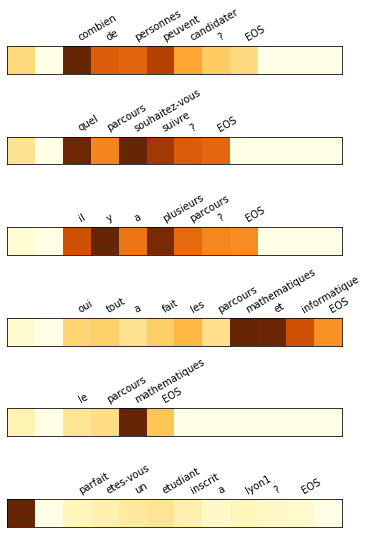

User :  non
target :  pour les etudiants du parcours mathematiques non-inscrits a lyon1 le nombre de places disponibles est de nbreplaces_en_france_mathematiques
predic :  pour les etudiants du parcours mathematiques non-inscrits a lyon1 le nombre de places disponibles est de nbreplaces_en_france_mathematiques


In [130]:
chatbot.eval()
dialogue = dialogues_Master_var[12][:4]
chatbot.showAttention(dialogue)

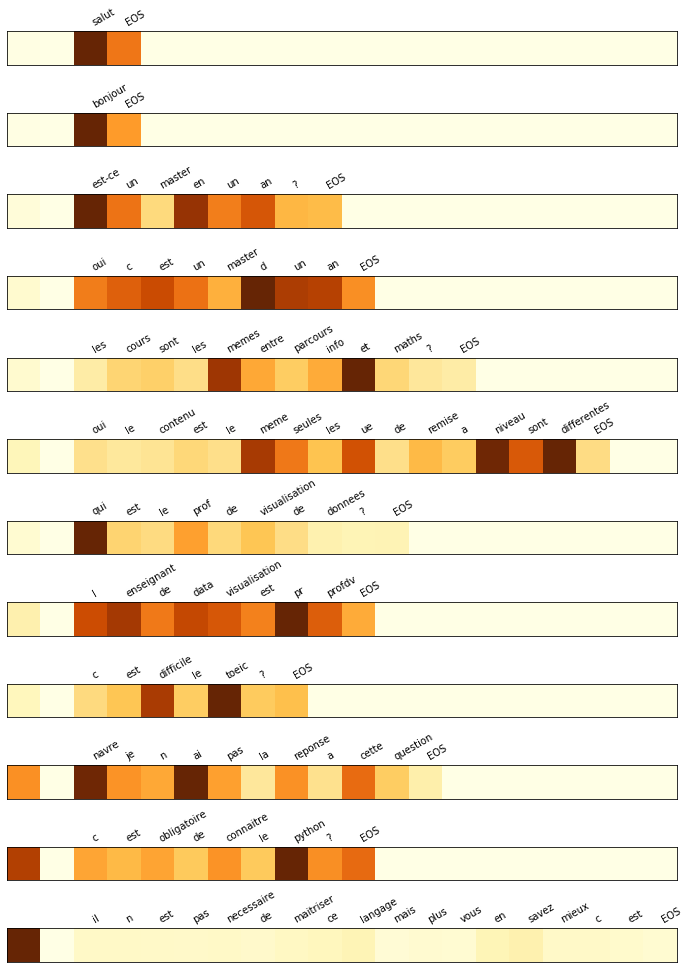

User :  il faut coder en php ?
target :  non aucun tp ne se fera en php
predic :  non aucun tp ne se fera en php


In [103]:
chatbot.eval()
dialogue = dialogues_Master_test_var[1][:7]
chatbot.showAttention(dialogue)

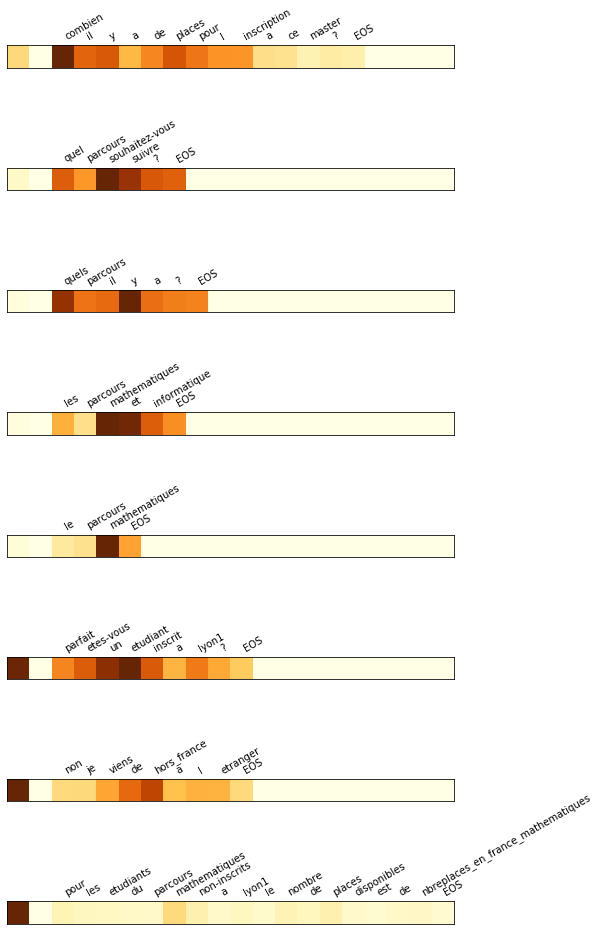

User :  a qui ce master est ouvert ?
target :  le master est ouvert aux etudiants titulaires d un master 1 en informatique mathematiques ou issus d un cursus ingenieur
predic :  la structure campus france est-elle implantee dans votre pays ?


In [135]:
chatbot.eval()
dialogue = dialogues_Master_test_var[373][:5]
chatbot.showAttention(dialogue)

### 6.4.3 Interactive mode

write **quit** or **q** or **eoc** (end of conversation) to close conversation interface :

In [104]:
def ReplaceMotVar(motsVar, raw_sentence):
    sentence = []
    word_list = raw_sentence.split(' ')
    for word in word_list :
        if word in motsVar.keys() :
            sentence.append(motsVar[word])
        else :
            sentence.append(word)
    return ' '.join(sentence)

def InteractiveEvaluation(agent) :
    agent.initMemory()
    while True :
        text = input()
        #print('User : {}'.format(text))
        if text == 'eoc' or text == 'q' or text == 'quit' : 
            break
        reponse, attn1_weights, attn2_weights = chatbot(text)
        reponse = ReplaceMotVar(motsVar, reponse)
        print('Bot  : {}'.format(reponse))

In [105]:
chatbot.eval()
InteractiveEvaluation(chatbot)

salut ma poule
Bot  : bonjour
comment tu vas ?
Bot  : je vais bien merci et vous ?
ca va pas mal
Bot  : gardez courage en quoi puis-je vous aider ?
je voudrais savoir a quel point tu sais parler
Bot  : excusez moi pouvez-vous reformuler votre requete ?
haaa c'est approprié ca
Bot  : oui vous devez faire un depot de candidature
je ne veux pas m'inscrire
Bot  : les inscriptions se font sur la plateforme e-candidat
quel est le lien ?
Bot  : il est compose de chercheurs du liris
tu palres bien mais tu dis n'importe quoi
Bot  : je m appelle Horace
je m'en fous
Bot  : les inscriptions se font sur la plateforme e-candidat
ok au revoir
Bot  : au revoir
quit
